# Reading/Fetching Data

In [133]:
import yfinance as yf
import datetime

# Set the ticker symbol 
# ticker = "USDIDR=X" # USD/IDR
# ticker = "^GSPC" # S&P 500
# ticker = "^JKSE" # IHSG
ticker = "USDJPY=X" # USD/IDR

# Define the data interval (use '1d' for daily or '1h' for hourly data)
interval = '1d'  # Change to '1h' for hourly data

# Download the historical data
# Define the start and end dates, e.g., for the past year

# Get today's date
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

yahoo_data = yf.download(ticker, start="2020-01-01", end=end_date, interval=interval)

# Reset index to turn 'date' from index into a column
yahoo_df = yahoo_data.reset_index()

# Rename the columns
yahoo_df.columns = ['date', 'adj_close', 'close', 'high', 'low', 'open', 'volume']

# Select and reorder columns as specified
yahoo_df = yahoo_df[['date', 'open', 'high', 'low', 'close', 'volume']]

# Display the updated DataFrame
yahoo_df

[*********************100%***********************]  1 of 1 completed


,date,open,high,low,close,volume
0,2020-01-01 00:00:00+00:00,108.680000,111.410004,108.629997,108.681000,0
1,2020-01-02 00:00:00+00:00,108.713997,108.860001,108.221001,108.712997,0
2,2020-01-03 00:00:00+00:00,108.540001,108.551003,107.915001,108.542999,0
3,2020-01-06 00:00:00+00:00,107.999001,108.410004,107.921997,107.963997,0
4,2020-01-07 00:00:00+00:00,108.411003,108.616997,108.261002,108.405998,0
...,...,...,...,...,...,...
1263,2024-11-04 00:00:00+00:00,152.287003,152.285004,151.550995,152.287003,0
1264,2024-11-05 00:00:00+00:00,152.276001,152.531006,151.796005,152.276001,0
1265,2024-11-06 00:00:00+00:00,151.434998,154.649994,151.343002,151.434998,0
1266,2024-11-07 00:00:00+00:00,154.320007,154.701996,152.860992,154.320007,0


In [29]:
import yfinance as yf
import datetime

# Define the tickers and custom DataFrame names
tickers = ["USDIDR=X", "^GSPC", "^JKSE"]
df_names = ["usd_idr_df", "snp500_df", "ihsg_df"]

# Define the data interval and time range
interval = '1d'  # Change to '1h' for hourly data
start_date = "2014-10-01"
end_date = datetime.datetime.today().strftime('%Y-%m-%d')  # Get today's date

# Initialize an empty dictionary to store DataFrames with custom names
dataframes = {}

# Download the data for each ticker and assign to the dictionary with the specified names
for ticker, name in zip(tickers, df_names):
    df = yf.download(ticker, start=start_date, end=end_date, interval=interval).reset_index()

    # Rename columns and select specific columns
    df.columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
    df = df[['date', 'open', 'high', 'low', 'close', 'volume']]

    # Assign the DataFrame to the specified name in the dictionary
    dataframes[name] = df

# Access each DataFrame by the custom names
usd_idr_df = dataframes["usd_idr_df"]
snp500_df = dataframes["snp500_df"]
ihsg_df = dataframes["ihsg_df"]

# Display each DataFrame as an example
print("USD/IDR DataFrame:\n", usd_idr_df.head())
print("S&P 500 DataFrame:\n", snp500_df.head())
print("IHSG DataFrame:\n", ihsg_df.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

USD/IDR DataFrame:
                        date     open     high      low    close  volume
0 2014-10-01 00:00:00+00:00  12175.0  12175.0  12215.0  12090.0       0
1 2014-10-02 00:00:00+00:00  12130.0  12130.0  12155.0  12070.0       0
2 2014-10-03 00:00:00+00:00  12112.0  12112.0  12246.0  12107.0       0
3 2014-10-06 00:00:00+00:00  12181.0  12181.0  12210.0  12152.0       0
4 2014-10-07 00:00:00+00:00  12147.0  12147.0  12250.0  12170.0       0
S&P 500 DataFrame:
                        date         open         high          low  \
0 2014-10-01 00:00:00+00:00  1946.160034  1946.160034  1971.439941   
1 2014-10-02 00:00:00+00:00  1946.170044  1946.170044  1952.319946   
2 2014-10-03 00:00:00+00:00  1967.900024  1967.900024  1971.189941   
3 2014-10-06 00:00:00+00:00  1964.819946  1964.819946  1977.839966   
4 2014-10-07 00:00:00+00:00  1935.099976  1935.099976  1962.359985   

         close      volume  
0  1941.719971  4188590000  
1  1926.030029  4012510000  
2  1948.119995  3560

In [9]:
import requests
import time

# Define the API endpoint and parameters
url = "https://api.binance.com/api/v3/klines"
params = {
    'symbol': 'USDTIDR',
    'interval': '1d',  # or '1h' for hourly data
    'startTime': int(time.mktime(time.strptime('2023-01-01', '%Y-%m-%d')) * 1000),  # Start time as timestamp
    'endTime': int(time.mktime(time.strptime('2023-12-31', '%Y-%m-%d')) * 1000),  # End time as timestamp
    'limit': 1000,
}

# Send the GET request to fetch the OHLC data
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    ohlc_data = response.json()
    # Process or display the data
    for entry in ohlc_data:
        print(entry)
else:
    print(f"Error fetching data: {response.status_code}")

Error fetching data: 400


In [10]:
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime
from urllib.parse import urlencode
import time

BINANCE_CANDLE_COLUMNS = ['opentime', 'openprice', 'highprice', 'lowprice', 'closeprice', 'volume', 'closetime',
                          'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused']

DATE_FORMAT = "%Y-%m-%d %H:%M:%S"

def binance_recursive_fetch_2(coins, interval, starttime, endtime):
    all_coins_result = {}
    data_list = []
    call_dict = {}
    for coin in tqdm(coins):
        result_list = []
        current_time = starttime
        call = 0
        timestamps = []
        while current_time < endtime:
            # Determine the limit
            if ((int((endtime - current_time)/(1000*60))) + 1) >= 1000:
                limit = 1000
            else:
                limit = int((endtime - current_time)/(1000*60) + 1)
                
            # Construct the URL using urlencode for cleaner handling of parameters
            params = {
                'symbol': f'{coin}',
                'startTime': str(current_time),
                'interval': interval,
                'limit': str(limit)
            }
            url = f'https://api.binance.com/api/v1/klines?{urlencode(params)}'
            
            try:
                response = requests.get(url)
                response.raise_for_status()  # Raise an exception for HTTP errors
                result_list += response.json()
            except requests.exceptions.RequestException as e:
                print(f"Error fetching data for {coin}: {e}")
                break  # Stop the loop if there is an error
            
            # Update current time to the next interval's start time
            current_time = result_list[-1][0] + 60000
            timestamps.append(current_time)
            call += 1
            print(f"{datetime.fromtimestamp(current_time / 1000).strftime(DATE_FORMAT)} - status: {current_time < endtime}, time: {current_time}, limit: {call * 2}")
            
            # Throttle requests to avoid hitting rate limits
            if (call % 60) == 0:
                print('Call reaches 60, waiting for 60 seconds')
                time.sleep(60)  # Wait to avoid rate-limiting
            if timestamps.count(current_time) > 1:
                break  # Break if there's duplicate timestamp (indicating an error)
        
        current_df = pd.DataFrame(result_list, columns=BINANCE_CANDLE_COLUMNS)
        current_df['coin'] = coin
        current_df = current_df[['coin'] + BINANCE_CANDLE_COLUMNS]
        current_df = np.matrix(current_df).tolist()
        data_list += current_df
        call_dict.update({coin: call})
    
    return {'data': np.matrix(data_list).tolist(), 'call': call_dict}

In [18]:
sample = binance_recursive_fetch_2(
    ['USDTIDRT'],  # List of trading pairs
    '1m',  # Interval
    starttime=int(pd.to_datetime('2018-01-01 00:00', utc=True).timestamp() * 1000),
    endtime=int(pd.to_datetime('2024-12-31 23:59', utc=True).timestamp() * 1000)
)

# Display the data
sample['data']

  0%|          | 0/1 [00:00<?, ?it/s]

2020-04-17 20:40:00 - status: True, time: 1587156000000, limit: 2
2020-04-18 13:20:00 - status: True, time: 1587216000000, limit: 4
2020-04-19 06:00:00 - status: True, time: 1587276000000, limit: 6
2020-04-19 22:40:00 - status: True, time: 1587336000000, limit: 8
2020-04-20 15:20:00 - status: True, time: 1587396000000, limit: 10
2020-04-21 08:00:00 - status: True, time: 1587456000000, limit: 12
2020-04-22 00:40:00 - status: True, time: 1587516000000, limit: 14
2020-04-22 17:20:00 - status: True, time: 1587576000000, limit: 16
2020-04-23 10:00:00 - status: True, time: 1587636000000, limit: 18
2020-04-24 02:40:00 - status: True, time: 1587696000000, limit: 20
2020-04-24 19:20:00 - status: True, time: 1587756000000, limit: 22
2020-04-25 14:30:00 - status: True, time: 1587825000000, limit: 24
2020-04-26 07:10:00 - status: True, time: 1587885000000, limit: 26
2020-04-26 23:50:00 - status: True, time: 1587945000000, limit: 28
2020-04-27 16:30:00 - status: True, time: 1588005000000, limit: 30

  0%|          | 0/1 [05:57<?, ?it/s]


KeyboardInterrupt: 

In [12]:
len(sample['data'])

227700

In [13]:
# The fetched data sample
data = sample['data']

# Define the column names
columns = ['coin', 'opentime', 'openprice', 'highprice', 'lowprice', 'closeprice', 'volume', 'closetime',
           'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused']

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=columns)

# # Convert 'opentime' and 'closetime' from Unix timestamp to datetime
# df['opentime'] = pd.to_datetime(df['opentime'], unit='ms')
# df['closetime'] = pd.to_datetime(df['closetime'], unit='ms')

# Display the DataFrame
df

,coin,opentime,openprice,highprice,lowprice,closeprice,volume,closetime,quotevolume,trades,taker_buy_volume,taker_buy_quote,unused
0,USDTIDRT,1717200000000,16288.00,16288.00,16288.00,16288.00,0.00000000,1717200059999,0.00,0,0.00000000,0.00,0
1,USDTIDRT,1717200060000,16288.00,16288.00,16288.00,16288.00,0.00000000,1717200119999,0.00,0,0.00000000,0.00,0
2,USDTIDRT,1717200120000,16288.00,16288.00,16288.00,16288.00,0.00000000,1717200179999,0.00,0,0.00000000,0.00,0
3,USDTIDRT,1717200180000,16288.00,16288.00,16288.00,16288.00,0.00000000,1717200239999,0.00,0,0.00000000,0.00,0
4,USDTIDRT,1717200240000,16288.00,16288.00,16288.00,16288.00,0.00000000,1717200299999,0.00,0,0.00000000,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
227695,USDTIDRT,1730861700000,15903.00,15903.00,15899.00,15899.00,64.00000000,1730861759999,1017756.00,4,64.00000000,1017756.00,0
227696,USDTIDRT,1730861760000,15899.00,15899.00,15899.00,15899.00,65.00000000,1730861819999,1033435.00,5,65.00000000,1033435.00,0
227697,USDTIDRT,1730861820000,15875.00,15899.00,15875.00,15899.00,70.00000000,1730861879999,1112864.00,8,70.00000000,1112864.00,0
227698,USDTIDRT,1730861880000,15899.00,15899.00,15899.00,15899.00,80.00000000,1730861939999,1271920.00,7,80.00000000,1271920.00,0


In [ ]:
import polars as pl
import pandas as pd

# Assuming you have the pandas DataFrame 'df' with your data

# Create a Polars DataFrame from the pandas DataFrame
usdt_idrt = pl.from_pandas(df)

# Rename columns (if needed) to match the structure you want
usdt_idrt = usdt_idrt.rename({
    'coin': 'coin',
    'opentime': 'opentime',
    'openprice': 'openprice',
    'highprice': 'highprice',
    'lowprice': 'lowprice',
    'closeprice': 'closeprice',
    'volume': 'volume',
    'closetime': 'closetime',
    'quotevolume': 'quotevolume',
    'trades': 'trades',
    'taker_buy_volume': 'taker_buy_volume',
    'taker_buy_quote': 'taker_buy_quote'
})

# Set appropriate data types for each column
usdt_idrt = usdt_idrt.with_columns([
    pl.col('coin').cast(pl.Utf8),  # coin as string
    pl.col('opentime').cast(pl.Int64),  # opentime as Int64 (milliseconds)
    pl.col('openprice').cast(pl.Float64),
    pl.col('highprice').cast(pl.Float64),
    pl.col('lowprice').cast(pl.Float64),
    pl.col('closeprice').cast(pl.Float64),
    pl.col('volume').cast(pl.Float64),
    pl.col('closetime').cast(pl.Int64),
    pl.col('quotevolume').cast(pl.Float64),
    pl.col('trades').cast(pl.Int64),
    pl.col('taker_buy_volume').cast(pl.Float64),
    pl.col('taker_buy_quote').cast(pl.Float64),
])

# Drop the 'unused' column
usdt_idrt = usdt_idrt.drop('unused')

# Display the result
usdt_idrt

coin,opentime,openprice,highprice,lowprice,closeprice,volume,closetime,quotevolume,trades,taker_buy_volume,taker_buy_quote
str,i64,f64,f64,f64,f64,f64,i64,f64,i64,f64,f64
"""USDTIDRT""",1717200000000,16288.0,16288.0,16288.0,16288.0,0.0,1717200059999,0.0,0,0.0,0.0
"""USDTIDRT""",1717200060000,16288.0,16288.0,16288.0,16288.0,0.0,1717200119999,0.0,0,0.0,0.0
"""USDTIDRT""",1717200120000,16288.0,16288.0,16288.0,16288.0,0.0,1717200179999,0.0,0,0.0,0.0
"""USDTIDRT""",1717200180000,16288.0,16288.0,16288.0,16288.0,0.0,1717200239999,0.0,0,0.0,0.0
"""USDTIDRT""",1717200240000,16288.0,16288.0,16288.0,16288.0,0.0,1717200299999,0.0,0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…
"""USDTIDRT""",1730861700000,15903.0,15903.0,15899.0,15899.0,64.0,1730861759999,1.017756e6,4,64.0,1.017756e6
"""USDTIDRT""",1730861760000,15899.0,15899.0,15899.0,15899.0,65.0,1730861819999,1.033435e6,5,65.0,1.033435e6
"""USDTIDRT""",1730861820000,15875.0,15899.0,15875.0,15899.0,70.0,1730861879999,1.112864e6,8,70.0,1.112864e6


In [ ]:
# import polars as pl

# # Read parquet file
# usdt_idrt = pl.read_parquet("USDT_IDRT.parquet")

# usdt_idrt

coin,opentime,openprice,highprice,lowprice,closeprice,volume,closetime,quotevolume,trades,taker_buy_volume,taker_buy_quote
str,i64,f64,f64,f64,f64,f64,i64,f64,i64,f64,f64
"""USDT""",1587096000000,15603.0,15603.0,3500.0,3800.0,2111.0,1587096059999,7.9510e6,12,180.42,665115.9
"""USDT""",1587096060000,3900.0,9999.0,3121.0,9999.0,1518.8,1587096119999,8.0077e6,30,569.4,4.3036e6
"""USDT""",1587096120000,9999.0,15400.0,3121.0,15300.0,3436.21,1587096179999,4.8426e7,26,1093.32,1.5983e7
"""USDT""",1587096180000,15300.0,15399.0,3905.0,13662.0,2006.86,1587096239999,2.5022e7,20,21.7,334158.3
"""USDT""",1587096240000,13662.0,15000.0,3905.0,15000.0,1858.21,1587096299999,2.1579e7,25,473.01,6.1570e6
…,…,…,…,…,…,…,…,…,…,…,…
"""USDT""",1729727700000,15691.0,15691.0,15691.0,15691.0,0.0,1729727759999,0.0,0,0.0,0.0
"""USDT""",1729727760000,15691.0,15691.0,15691.0,15691.0,0.0,1729727819999,0.0,0,0.0,0.0
"""USDT""",1729727820000,15691.0,15691.0,15691.0,15691.0,5.0,1729727879999,78455.0,1,0.0,0.0


# Yahoo Data Test

In [111]:
# Convert the 'date' column to the desired format (YYYY-MM-DD)
yahoo_df['date'] = yahoo_df['date'].dt.strftime('%Y-%m-%d')

yahoo_df

,date,open,high,low,close
0,2011-11-30,9179.950195,9179.950195,9080.900391,9120.500000
1,2011-12-01,9074.950195,9100.000000,8820.299805,9076.700195
2,2011-12-02,9097.450195,9107.450195,8826.299805,8994.950195
3,2011-12-05,9064.950195,9074.950195,8864.500000,9014.950195
4,2011-12-06,9054.950195,9087.450195,9006.799805,9016.599609
...,...,...,...,...,...
3366,2024-10-31,15695.500000,15751.200195,15672.500000,15695.500000
3367,2024-11-01,15713.000000,15794.000000,15633.200195,15713.000000
3368,2024-11-04,15842.000000,15842.000000,15719.000000,15842.000000
3369,2024-11-05,15790.000000,15791.900391,15707.700195,15790.000000


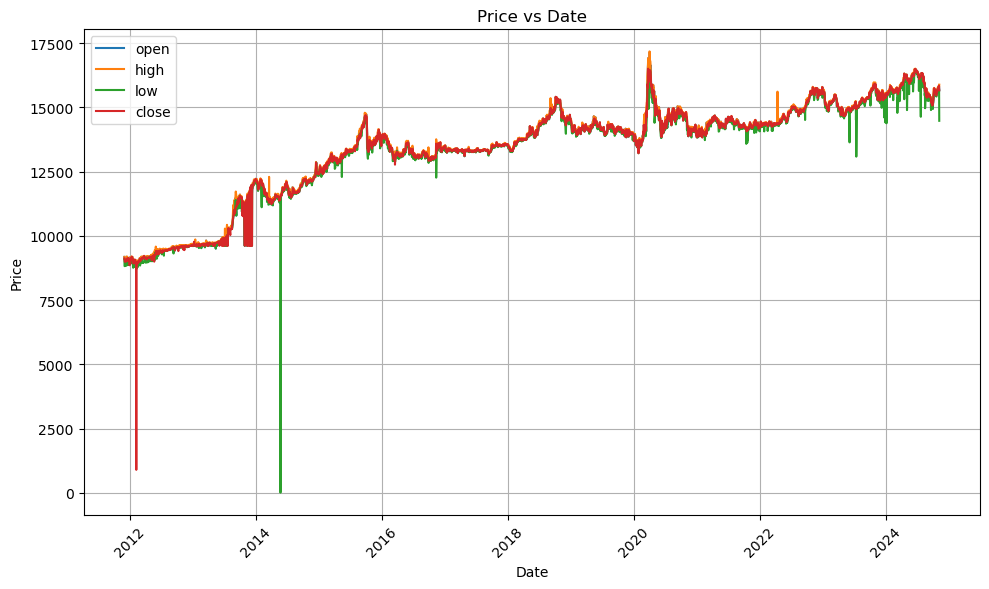

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the 'date' column to the desired format (YYYY-MM-DD)
yahoo_df['date'] = yahoo_df['date'].dt.strftime('%Y-%m-%d')

# Ensure the 'date' column is in datetime format for proper plotting
yahoo_df['date'] = pd.to_datetime(yahoo_df['date'])

# Convert the 'date' column to a NumPy array for plotting
date_array = yahoo_df['date'].to_numpy()

# Create a plot for each column
plt.figure(figsize=(10, 6))

# Plot each column against 'date'
for column in ['open', 'high', 'low', 'close']:
    plt.plot(date_array, yahoo_df[column].to_numpy(), label=column)

# Customize the plot
plt.title('Price vs Date')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Display the plot
plt.tight_layout()
plt.show()

In [116]:
# Copy the df
df_feature = yahoo_df.copy()

# Ensure 'date' is consistently used as a datetime format
df_feature['date'] = pd.to_datetime(df_feature['date'])

# Features Engineering

# Create the next_close column as the target variable to be predicted
df_feature['next_close'] = df_feature['close'].shift(-1)

# Count the next day gap
df_feature['gap_day'] = df_feature['date'].shift(-1) - df_feature['date']
# Convert gap_day to just the number of days and make it an integer
df_feature['gap_day'] = df_feature['gap_day'].dt.days.fillna(0).astype(int)

# Calculate the changes from the previous row for OHLC
df_feature['open_change'] = df_feature['open'].diff()
df_feature['high_change'] = df_feature['high'].diff()
df_feature['low_change'] = df_feature['low'].diff()
df_feature['close_change'] = df_feature['close'].diff()

# Function to calculate moving average over a custom date range
def custom_moving_average(df, close_col, date_col, days):
    averages = []
    for index, row in df.iterrows():
        current_date = row[date_col]
        # Get the date range
        start_date = current_date - pd.Timedelta(days=days)
        # Filter the DataFrame for the desired date range
        mask = (df[date_col] >= start_date) & (df[date_col] <= current_date)
        # Calculate the mean for the filtered values
        avg = df.loc[mask, close_col].mean()
        averages.append(avg)
    return averages

# Calculate the custom moving averages
df_feature['ma_close_5'] = custom_moving_average(df_feature, 'close', 'date', days=4)  # 4 previous days + today
df_feature['ma_close_10'] = custom_moving_average(df_feature, 'close', 'date', days=9)  # 9 previous days + today

# Capture previous values
df_feature['prev_open'] = df_feature['open'].shift(1)
df_feature['prev_high'] = df_feature['high'].shift(1)
df_feature['prev_low'] = df_feature['low'].shift(1)
df_feature['prev_close'] = df_feature['close'].shift(1)

# Add daily range (high-low)
df_feature['daily_range'] = df_feature['high'] - df_feature['low']

# Add gap change (today's open - previous close)
df_feature['gap_change'] = df_feature['open'] - df_feature['prev_close']

# Add close-to-moving average ratios
df_feature['close_ma5_ratio'] = df_feature['close'] / df_feature['ma_close_5']
df_feature['close_ma10_ratio'] = df_feature['close'] / df_feature['ma_close_10']

# Drop columns that are not needed for prediction
df_feature = df_feature[['date', 'open', 'high', 'low', 'close', 'gap_day', 
         'next_close', 'open_change', 'high_change', 
         'low_change', 'close_change', 'ma_close_5', 
         'ma_close_10', 'prev_open', 'prev_high', 
         'prev_low', 'prev_close', 'daily_range', 'gap_change',
         'close_ma5_ratio', 'close_ma10_ratio']]

# Others Features Engineering
df_feature['open_change_perc'] = df_feature['open_change'] / df_feature['prev_open']
df_feature['high_change_perc'] = df_feature['high_change'] / df_feature['prev_high']
df_feature['low_change_perc'] = df_feature['low_change'] / df_feature['prev_low']
df_feature['close_change_perc'] = df_feature['close_change'] / df_feature['prev_close']

df_feature['prev_daily_range'] = df_feature['prev_high'] - df_feature['prev_low']
df_feature['daily_range_change'] = df_feature['daily_range'] - df_feature['prev_daily_range']

df_feature['open_prev_close_change'] = df_feature['open'] - df_feature['prev_close']

df_feature['volatility'] = ((df_feature['high'] - df_feature['low']) / df_feature['open']) * 100
df_feature['prev_volatility'] = ((df_feature['prev_high'] - df_feature['prev_low']) / df_feature['prev_open']) * 100
df_feature['volatility_change'] = df_feature['volatility'] - df_feature['prev_volatility']

# Filter the DataFrame to include only rows from the year onwards
df_feature = df_feature[df_feature['date'] >= '2014-06-01']

df_feature

,date,open,high,low,close,gap_day,next_close,open_change,high_change,low_change,...,open_change_perc,high_change_perc,low_change_perc,close_change_perc,prev_daily_range,daily_range_change,open_prev_close_change,volatility,prev_volatility,volatility_change
651,2014-06-02,11728.0,11810.000000,11707.000000,11660.0,1,11760.0,126.0,85.000000,119.000000,...,0.010860,0.007249,0.010269,0.005606,137.000000,-34.000000,133.0,0.878240,1.180831,-0.302591
652,2014-06-03,11765.0,11820.000000,11765.000000,11760.0,1,11770.0,37.0,10.000000,58.000000,...,0.003155,0.000847,0.004954,0.008576,103.000000,-48.000000,105.0,0.467488,0.878240,-0.410752
653,2014-06-04,11828.0,11900.000000,11795.000000,11770.0,1,11880.0,63.0,80.000000,30.000000,...,0.005355,0.006768,0.002550,0.000850,55.000000,50.000000,68.0,0.887724,0.467488,0.420236
654,2014-06-05,11885.0,11901.000000,11735.000000,11880.0,1,11845.0,57.0,1.000000,-60.000000,...,0.004819,0.000084,-0.005087,0.009346,105.000000,61.000000,115.0,1.396719,0.887724,0.508995
655,2014-06-06,11850.0,11852.000000,11690.000000,11845.0,3,11815.0,-35.0,-49.000000,-45.000000,...,-0.002945,-0.004117,-0.003835,-0.002946,166.000000,-4.000000,-30.0,1.367089,1.396719,-0.029630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3366,2024-10-31,15695.5,15751.200195,15672.500000,15695.5,1,15713.0,-72.5,-16.799805,44.400391,...,-0.004598,-0.001065,0.002841,-0.004598,139.900391,-61.200195,-72.5,0.501419,0.887242,-0.385824
3367,2024-11-01,15713.0,15794.000000,15633.200195,15713.0,3,15842.0,17.5,42.799805,-39.299805,...,0.001115,0.002717,-0.002508,0.001115,78.700195,82.099609,17.5,1.023355,0.501419,0.521936
3368,2024-11-04,15842.0,15842.000000,15719.000000,15842.0,1,15790.0,129.0,48.000000,85.799805,...,0.008210,0.003039,0.005488,0.008210,160.799805,-37.799805,129.0,0.776417,1.023355,-0.246938
3369,2024-11-05,15790.0,15791.900391,15707.700195,15790.0,1,15665.0,-52.0,-50.099609,-11.299805,...,-0.003282,-0.003162,-0.000719,-0.003282,123.000000,-38.799805,-52.0,0.533250,0.776417,-0.243167


In [117]:
df_feature['gap_day'].unique()

array([1, 3, 2, 0])

In [123]:
from sklearn.linear_model import LinearRegression

# Separate df into features and target
features_df = df_feature.drop(['date', 'next_close'], axis=1)
target_df = df_feature['next_close']

# Convert to NumPy arrays
X = features_df.values
y = target_df.values

# Specify parameters for the sliding window approach
num_predictions = 1   # Number of rows to predict
gap = 1               # Gap (number of rows to skip after each window)
max_windows = 50      # Maximum number of windows to process
set_limit = False     # Set this to False to process all windows

# Define list of window sizes
window_sizes = [437] # Optimum
# window_sizes = list(range(420, 441, 1))

# List to store results
results = []

# Loop through each window size
for window_size in window_sizes:

    # Initiate lists to store RMSEs and percentages
    all_val_rmse = []
    all_val_rmse_perc = []
    all_train_rmse = []
    all_train_rmse_perc = []

    # Calculate the number of windows based on dataset size
    num_windows = len(X) - window_size - num_predictions

    # Apply maximum window limit if set
    if set_limit:
        num_windows = min(num_windows, max_windows)

    # Loop through each sliding window with the gap applied
    window_number = 0
    while window_number < num_windows:
        start = window_number
        end = start + window_size
        X_train = X[start:end]
        y_train = y[start:end]

        # Prepare validation data for prediction
        X_val = X[end:end + num_predictions]
        y_val = y[end:end + num_predictions]

        # Initialize and fit the model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Predict on validation data
        y_pred_val = model.predict(X_val)
        # Predict on training data
        y_pred_train = model.predict(X_train)

        # Calculate RMSE and RMSE percentage for validation
        mse_val = np.mean((y_val - y_pred_val) ** 2)
        rmse_val = np.sqrt(mse_val)
        rmse_val_perc = (rmse_val / y_val)[0] * 100  # Convert to percentage

        # Calculate RMSE for training
        mse_train = np.mean((y_train - y_pred_train) ** 2)
        rmse_train = np.sqrt(mse_train)
        rmse_train_perc = (rmse_train / y_train).mean() * 100  # Convert to percentage

        # Append RMSEs and percentage errors
        all_val_rmse.append(rmse_val)
        all_val_rmse_perc.append(rmse_val_perc)
        all_train_rmse.append(rmse_train)
        all_train_rmse_perc.append(rmse_train_perc)

        # Move to the next window based on the gap
        window_number += gap

    # Calculate average, max, min, and variance for validation and training RMSEs, percentages
    avg_val_rmse = np.mean(all_val_rmse)
    # min_val_rmse = min(all_val_rmse)
    # max_val_rmse = max(all_val_rmse)
    var_val_rmse = np.var(all_val_rmse)

    avg_val_rmse_perc = np.mean(all_val_rmse_perc)
    # min_val_rmse_perc = min(all_val_rmse_perc)
    # max_val_rmse_perc = max(all_val_rmse_perc)
    var_val_rmse_perc = np.var(all_val_rmse_perc)

    avg_train_rmse = np.mean(all_train_rmse)
    # min_train_rmse = min(all_train_rmse)
    # max_train_rmse = max(all_train_rmse)
    var_train_rmse = np.var(all_train_rmse)

    avg_train_rmse_perc = np.mean(all_train_rmse_perc)
    # min_train_rmse_perc = min(all_train_rmse_perc)
    # max_train_rmse_perc = max(all_train_rmse_perc)
    var_train_rmse_perc = np.var(all_train_rmse_perc)

    # Append results to the list
    results.append({
        'window_size': window_size,
        # 'min_val_rmse': min_val_rmse,
        # 'max_val_rmse': max_val_rmse,
        'avg_val_rmse': avg_val_rmse,
        'var_val_rmse': var_val_rmse,
        # 'min_val_rmse_perc': min_val_rmse_perc,
        # 'max_val_rmse_perc': max_val_rmse_perc,
        'avg_val_rmse_perc': avg_val_rmse_perc,
        'var_val_rmse_perc': var_val_rmse_perc,
        # 'min_train_rmse': min_train_rmse,
        # 'max_train_rmse': max_train_rmse,
        'avg_train_rmse': avg_train_rmse,
        'var_train_rmse': var_train_rmse,
        # 'min_train_rmse_perc': min_train_rmse_perc,
        # 'max_train_rmse_perc': max_train_rmse_perc,
        'avg_train_rmse_perc': avg_train_rmse_perc,
        'var_train_rmse_perc': var_train_rmse_perc,
    })

    # Print results for the current window size
    print(f'Window size {window_size} | Avg Training RMSE: {avg_train_rmse:.3f}, Var Training RMSE: {var_train_rmse:.3f}')
    print(f'Window size {window_size} | Avg Validation RMSE: {avg_val_rmse:.3f}, Var Validation RMSE: {var_val_rmse:.3f}')

# Convert results to a DataFrame
results_summary = pd.DataFrame(results)

# Print the resulting DataFrame
print("\nSummary of RMSE Results for Each Window Size:")
results_summary

Window size 437 | Avg Training RMSE: 60.134, Var Training RMSE: 463.857
Window size 437 | Avg Validation RMSE: 47.709, Var Validation RMSE: 4291.721

Summary of RMSE Results for Each Window Size:


,window_size,avg_val_rmse,var_val_rmse,avg_val_rmse_perc,var_val_rmse_perc,avg_train_rmse,var_train_rmse,avg_train_rmse_perc,var_train_rmse_perc
0,437,47.708928,4291.721173,0.329184,0.201578,60.133593,463.857395,0.424372,0.022315


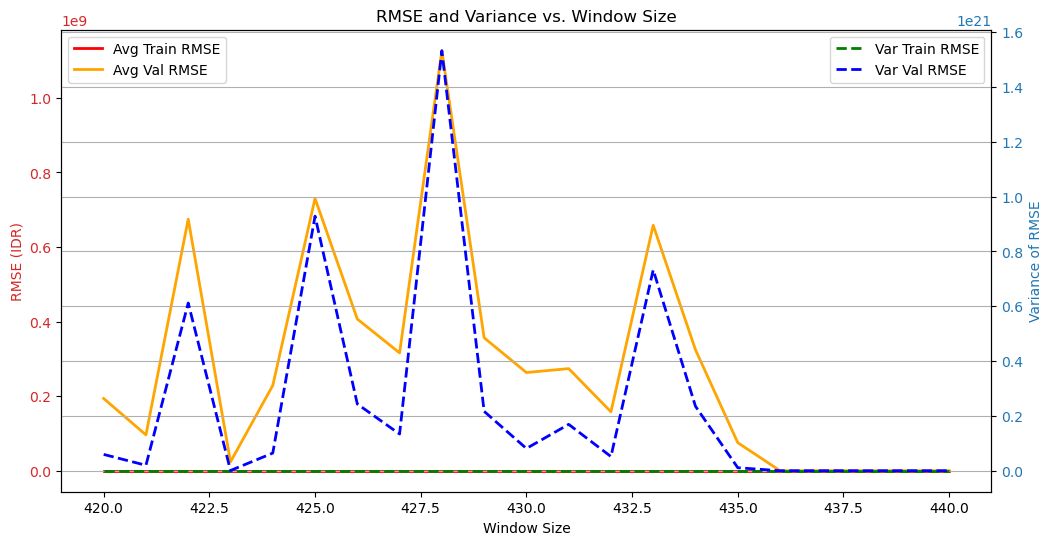

In [122]:
import matplotlib.pyplot as plt

# Ensure you have results_summary populated before running this code
if not results_summary.empty:
    # Plotting RMSE and Variance
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # RMSE Plot
    color = 'tab:red'
    ax1.set_xlabel('Window Size')
    ax1.set_ylabel('RMSE (IDR)', color=color)

    # Plot average RMSE as lines without points
    ax1.plot(results_summary['window_size'].values, results_summary['avg_train_rmse'].values, 
              label='Avg Train RMSE', color='red', linewidth=2)
    ax1.plot(results_summary['window_size'].values, results_summary['avg_val_rmse'].values, 
              label='Avg Val RMSE', color='orange', linewidth=2)

    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    # Create a second y-axis for variance
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Variance of RMSE', color=color)  # Set the label for the second Y axis

    # Plot variance of RMSE as lines without points
    ax2.plot(results_summary['window_size'].values, results_summary['var_train_rmse'].values, 
             label='Var Train RMSE', color='green', linestyle='--', linewidth=2)
    ax2.plot(results_summary['window_size'].values, results_summary['var_val_rmse'].values, 
             label='Var Val RMSE', color='blue', linestyle='--', linewidth=2)

    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title('RMSE and Variance vs. Window Size')
    plt.grid()
    plt.show()
else:
    print("Results summary is empty.")

In [125]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Separate df into features and target
features_df = df_feature.drop(['date', 'next_close'], axis=1)
target_df = df_feature['next_close']
date_df = df_feature['date']

# Convert to NumPy arrays
X = features_df.values
y = target_df.values

# Specify parameters for the sliding window approach
window_size = 437  # Optimal window size
gap = 1            # Step size of each window
num_display = 11    # Number of recent predictions to display

# Lists to store validation and training RMSEs (excluding the last window from avg calculations)
all_val_rmse = []
all_val_rmse_perc = []
all_train_rmse = []
all_train_rmse_perc = []

# Store predictions only for the final days
last_predictions = []

# Number of windows to process
num_windows = len(X) - window_size - 1  # Exclude last row for training

# Loop through each sliding window
window_number = 0
while window_number <= num_windows:
    start = window_number
    end = start + window_size
    X_train = X[start:end]
    y_train = y[start:end]

    # Prepare validation data for prediction
    if end < len(X) - 1:  # Ensure there's data for validation
        X_val = X[end:end + 1]  # Validation is the next row after the current window
        y_val = y[end:end + 1]  # The target for validation
        val_date = date_df.iloc[end:end + 1].values  # Get the date for validation

        # Skip this iteration if y_train contains NaN
        if np.isnan(y_train).any() or np.isnan(y_val).any():
            window_number += gap
            continue

        # Initialize and fit the model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Predict on validation data
        y_pred_val = model.predict(X_val)

        # Calculate RMSE and RMSE percentage for validation
        mse_val = np.mean((y_val - y_pred_val) ** 2)
        rmse_val = np.sqrt(mse_val)
        rmse_val_perc = (rmse_val / y_val)[0] * 100  # Convert to percentage

        # Calculate RMSE for training
        y_pred_train = model.predict(X_train)
        mse_train = np.mean((y_train - y_pred_train) ** 2)
        rmse_train = np.sqrt(mse_train)
        rmse_train_perc = (rmse_train / y_train).mean() * 100  # Convert to percentage

        # Append RMSEs and percentage errors, excluding the last window from averages
        if end < len(X) - 1:  # Only add if it's not the last window
            all_val_rmse.append(rmse_val)
            all_val_rmse_perc.append(rmse_val_perc)
            all_train_rmse.append(rmse_train)
            all_train_rmse_perc.append(rmse_train_perc)

        # Check if we're in the last 3 windows to display
        if end >= len(X) - num_display:
            # Use the date for the next row as the prediction date
            next_row_date = date_df.iloc[end + 1]
            last_predictions.append((next_row_date, y_val[0], y_pred_val[0]))

    # Move to the next window based on the gap
    window_number += gap

# Use the features of the last row for prediction
if len(X) > 0:
    last_row_features = X[-1].reshape(1, -1)  # Reshape to 2D for prediction
    last_row_pred = model.predict(last_row_features)
    last_row_date = date_df.iloc[-1]

    # Append the last row prediction with the correct date
    last_predictions.append((last_row_date + pd.Timedelta(days=1), np.nan, last_row_pred[0]))

# Print the most recent predictions and actual values for the last three days
print("\nRecent Predictions and Actual Values:")
for i, (date, actual, pred) in enumerate(reversed(last_predictions)):
    if np.isnan(actual):
        print(f"Date: {date.date()}, Prediction: {pred:.0f}")
    else:
        error = abs(actual - pred)  # Calculate the absolute error
        error_perc = ((pred/actual)-1)*100
        print(f"Date: {date.date()}, Prediction: {pred:.0f}, Actual: {actual:.0f},  Error: {error:.0f}, Error %: {error_perc:.2f}%")


Recent Predictions and Actual Values:
Date: 2024-11-07, Prediction: 15803
Date: 2024-11-06, Prediction: 15751, Actual: 15665,  Error: 86, Error %: 0.55%
Date: 2024-11-05, Prediction: 15797, Actual: 15790,  Error: 7, Error %: 0.05%
Date: 2024-11-04, Prediction: 15741, Actual: 15842,  Error: 101, Error %: -0.64%
Date: 2024-11-01, Prediction: 15719, Actual: 15713,  Error: 6, Error %: 0.04%
Date: 2024-10-31, Prediction: 15727, Actual: 15696,  Error: 32, Error %: 0.20%
Date: 2024-10-30, Prediction: 15753, Actual: 15768,  Error: 15, Error %: -0.10%
Date: 2024-10-29, Prediction: 15709, Actual: 15747,  Error: 38, Error %: -0.24%
Date: 2024-10-28, Prediction: 15636, Actual: 15688,  Error: 52, Error %: -0.33%
Date: 2024-10-25, Prediction: 15610, Actual: 15622,  Error: 12, Error %: -0.08%
Date: 2024-10-24, Prediction: 15663, Actual: 15663,  Error: 0, Error %: 0.00%


In [88]:
import polars as pl

# Read parquet file
usdt_idrt = pl.read_parquet("USDT_IDRT.parquet")

# Convert to Pandas DataFrame
usdt_idrt = usdt_idrt.to_pandas()
usdt_idrt

usdt_idrt['opentime'] = pd.to_datetime(usdt_idrt['opentime'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')
usdt_idrt['closetime'] = pd.to_datetime(usdt_idrt['closetime'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')

# Convert 'opentime' and 'closetime' to datetime
usdt_idrt['opentime'] = pd.to_datetime(usdt_idrt['opentime'])
usdt_idrt['closetime'] = pd.to_datetime(usdt_idrt['closetime'])

# Calculate Volume-Weighted Average Price (VWAP)
usdt_idrt['vwap'] = 0  # Default to 0
usdt_idrt.loc[usdt_idrt['volume'] != 0, 'vwap'] = usdt_idrt['quotevolume'] / usdt_idrt['volume']

# Calculate Average Trade Size
usdt_idrt['avg_trade_size'] = 0  # Default to 0
usdt_idrt.loc[usdt_idrt['trades'] != 0, 'avg_trade_size'] = usdt_idrt['volume'] / usdt_idrt['trades']

# Calculate Trade Count Change (difference in trades from previous row)
usdt_idrt['trade_count_change'] = usdt_idrt['trades'].diff()

# Calculate Taker Buy Volume Ratio
usdt_idrt['taker_buy_volume_ratio'] = 0  # Default to 0
usdt_idrt.loc[usdt_idrt['volume'] != 0, 'taker_buy_volume_ratio'] = usdt_idrt['taker_buy_volume'] / usdt_idrt['volume']

# Calculate Taker Buy Quote Ratio
usdt_idrt['taker_buy_quote_ratio'] = 0  # Default to 0
usdt_idrt.loc[usdt_idrt['quotevolume'] != 0, 'taker_buy_quote_ratio'] = usdt_idrt['taker_buy_quote'] / usdt_idrt['quotevolume']

# Calculate Daily Volume Change
usdt_idrt['daily_volume_change'] = usdt_idrt['volume'].diff()

# Calculate Daily Quote Volume Change
usdt_idrt['daily_quote_volume_change'] = usdt_idrt['quotevolume'].diff()

# Calculate Buy/Sell Volume Imbalance
usdt_idrt['buy_sell_volume_imbalance'] = abs(usdt_idrt['taker_buy_volume'] - (usdt_idrt['volume'] - usdt_idrt['taker_buy_volume']))

# Calculate Relative Volume (volume compared to 5-period MA of volume)
usdt_idrt['ma_volume_5'] = usdt_idrt['volume'].rolling(window=5).mean()
usdt_idrt['relative_volume'] = 0  # Default to 0
usdt_idrt.loc[usdt_idrt['ma_volume_5'] != 0, 'relative_volume'] = usdt_idrt['volume'] / usdt_idrt['ma_volume_5']

# Calculate Volume Volatility (standard deviation of volume over a rolling window)
usdt_idrt['volume_volatility'] = usdt_idrt['volume'].rolling(window=5).std()

# Volume Spike Indicator (1 if volume > 1.5 times the 5-period moving average, else 0)
usdt_idrt['volume_spike'] = (usdt_idrt['volume'] > 1.5 * usdt_idrt['ma_volume_5']).astype(int)

# Calculate Price-to-Volume Ratio
usdt_idrt['price_to_volume_ratio'] = 0  # Default to 0
usdt_idrt.loc[usdt_idrt['volume'] != 0, 'price_to_volume_ratio'] = usdt_idrt['closeprice'] / usdt_idrt['volume']

# Calculate Trade Frequency per Minute (assuming 1-minute intervals in the data)
usdt_idrt['trades_per_minute'] = usdt_idrt['trades']  # Assuming this is valid as it is

# Calculate Taker Buy Volume Change
usdt_idrt['taker_buy_volume_change'] = usdt_idrt['taker_buy_volume'].diff()

# Drop the intermediate 'ma_volume_5' column if it is no longer needed
usdt_idrt = usdt_idrt.drop(columns=['ma_volume_5'])

# Calculate duration in minutes
usdt_idrt['duration_minutes'] = (usdt_idrt['closetime'] - usdt_idrt['opentime']).dt.total_seconds() / 60

# Drop rows with NaN values
usdt_idrt = usdt_idrt.dropna()

# First, make sure 'opentime' is set as the DataFrame index or create a 'date' column.
usdt_idrt['date'] = usdt_idrt['opentime'].dt.date

# Group by date and aggregate features
daily_agg = usdt_idrt.groupby('date').agg({
    'openprice': 'first',
    'highprice': 'max',
    'lowprice': 'min',
    'closeprice': 'last',
    'volume': 'sum',
    'quotevolume': 'sum',
    'vwap': 'mean',
    'avg_trade_size': 'mean',
    'trade_count_change': 'mean',
    'taker_buy_volume_ratio': 'mean',
    'daily_volume_change': 'mean',  # You might want to sum or calculate the mean
    'buy_sell_volume_imbalance': 'mean',
    'relative_volume': 'mean',
    'volume_volatility': 'mean',
    'volume_spike': 'sum',  # Count the number of spikes
    'price_to_volume_ratio': 'mean',
    'trades_per_minute': 'sum',  # Total number of trades
    'taker_buy_volume_change': 'mean'
}).reset_index()

# Optionally, you can rename the columns for clarity
daily_agg.columns = ['date', 'daily_open', 'daily_high', 'daily_low', 'daily_close', 
                     'total_volume', 'total_quote_volume', 'avg_vwap', 'avg_trade_size',
                     'avg_trade_count_change', 'avg_taker_buy_volume_ratio', 
                     'daily_volume_change', 'avg_buy_sell_volume_imbalance', 
                     'avg_relative_volume', 'avg_volume_volatility', 
                     'count_volume_spikes', 'avg_price_to_volume_ratio', 
                     'total_trades', 'avg_taker_buy_volume_change']

# Display the aggregated DataFrame
daily_agg

/tmp/ipykernel_2192050/1995931850.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3766.46045476  5272.37658019 14092.81954537 ... 15692.
 15691.         15693.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  usdt_idrt.loc[usdt_idrt['volume'] != 0, 'vwap'] = usdt_idrt['quotevolume'] / usdt_idrt['volume']
/tmp/ipykernel_2192050/1995931850.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[175.91666667  50.62666667 132.16192308 ...   3.           5.
   5.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  usdt_idrt.loc[usdt_idrt['trades'] != 0, 'avg_trade_size'] = usdt_idrt['volume'] / usdt_idrt['trades']
/tmp/ipykernel_2192050/1995931850.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future er

,date,daily_open,daily_high,daily_low,daily_close,total_volume,total_quote_volume,avg_vwap,avg_trade_size,avg_trade_count_change,avg_taker_buy_volume_ratio,daily_volume_change,avg_buy_sell_volume_imbalance,avg_relative_volume,avg_volume_volatility,count_volume_spikes,avg_price_to_volume_ratio,total_trades,avg_taker_buy_volume_change
0,2020-04-17,13662.0,16000.0,3123.0,15503.0,117773.22,1.745741e+09,4184.960047,16.010277,-0.016722,0.110303,-1.677977e+00,69.929916,0.634691,109.439210,176,676.275536,1673,-1.814381e-02
1,2020-04-18,15503.0,15690.0,15367.0,15367.0,13578.59,2.114804e+08,1576.090429,5.127961,0.000000,0.020952,0.000000e+00,8.901229,0.351330,17.100600,110,210.212877,282,0.000000e+00
2,2020-04-19,15367.0,15698.0,15367.0,15415.0,7616.11,1.184481e+08,1512.133770,2.620806,0.000000,0.020575,0.000000e+00,5.084688,0.264288,8.442812,77,169.595275,283,0.000000e+00
3,2020-04-20,15421.0,15899.0,15410.0,15485.0,14347.61,2.231153e+08,929.999932,4.010586,0.000000,0.027481,3.947460e-17,8.322229,0.248679,19.744689,76,59.723809,185,0.000000e+00
4,2020-04-21,15485.0,15993.0,15440.0,15911.0,9698.54,1.517452e+08,750.737316,2.446892,0.001389,0.021210,1.503472e-02,6.272625,0.181492,13.008142,56,375.955912,161,-7.894919e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646,2024-10-19,15528.0,15528.0,15500.0,15501.0,252320.00,3.915541e+09,3296.820128,92.211597,0.000000,0.098023,0.000000e+00,173.206944,0.618322,359.345575,197,327.005326,422,0.000000e+00
1647,2024-10-20,15501.0,15525.0,15480.0,15481.0,210107.00,3.256743e+09,3477.544491,85.363461,0.000694,0.096772,9.722222e-03,145.156250,0.657541,301.288598,211,350.624188,444,9.722222e-03
1648,2024-10-21,15481.0,15580.0,15425.0,15573.0,683269.00,1.060203e+10,4052.405508,219.996603,-0.000694,0.145055,-9.722222e-03,471.202083,0.707283,847.127105,235,363.594107,575,-9.722222e-03
1649,2024-10-22,15573.0,15630.0,15556.0,15602.0,676648.00,1.056665e+10,4475.066185,265.101246,0.000000,0.159303,0.000000e+00,463.681944,0.752574,775.014637,251,371.860695,624,0.000000e+00


In [89]:
# Convert 'date' column in both DataFrames to datetime
daily_agg['date'] = pd.to_datetime(daily_agg['date'])
df_feature['date'] = pd.to_datetime(df_feature['date'])

# Perform an inner join on the 'date' column
combined_df = pd.merge(daily_agg, df_feature, on='date', how='inner')

# Display the combined DataFrame
combined_df

,date,daily_open,daily_high,daily_low,daily_close,total_volume,total_quote_volume,avg_vwap,avg_trade_size,avg_trade_count_change,...,open_change_perc,high_change_perc,low_change_perc,close_change_perc,prev_daily_range,daily_range_change,open_prev_close_change,volatility,prev_volatility,volatility_change
0,2020-04-17,13662.0,16000.0,3123.0,15503.0,117773.22,1.745741e+09,4184.960047,16.010277,-0.016722,...,-0.003778,-0.003778,0.004158,-0.020089,561.500000,-123.700195,-66.500000,2.767207,3.535672,-0.768465
1,2020-04-20,15421.0,15899.0,15410.0,15485.0,14347.61,2.231153e+08,929.999932,4.010586,0.000000,...,-0.040984,-0.010050,-0.013709,-0.009336,437.799805,51.889648,-395.749023,3.227461,2.767207,0.460254
2,2020-04-21,15485.0,15993.0,15440.0,15911.0,9698.54,1.517452e+08,750.737316,2.446892,0.001389,...,0.035552,0.003192,0.013391,-0.002977,489.689453,-153.169922,289.000000,2.141799,3.227461,-1.085662
3,2020-04-22,15911.0,15921.0,15460.0,15749.0,14074.26,2.204297e+08,1064.968963,3.414342,-0.001389,...,0.010406,0.010406,0.000824,0.001144,336.519531,150.823242,498.419922,3.069779,2.141799,0.927980
4,2020-04-23,15749.0,15749.0,15422.0,15720.0,8988.69,1.400388e+08,865.273854,2.523052,0.000000,...,-0.006614,-0.006614,0.001858,0.000906,487.342773,-133.589844,375.821289,2.243131,3.069779,-0.826648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,2024-10-17,15542.0,15570.0,15518.0,15569.0,312594.00,4.860566e+09,3520.618633,140.941887,0.000000,...,0.000340,0.000449,-0.000865,0.000340,84.400391,20.399414,5.300781,0.672488,0.541771,0.130716
1175,2024-10-18,15569.0,15570.0,15465.0,15528.0,385257.00,5.978781e+09,3727.649046,130.234439,0.000000,...,-0.005833,-0.003978,-0.002661,-0.005833,104.799805,-20.799805,-90.900391,0.542180,0.672488,-0.130307
1176,2024-10-21,15481.0,15580.0,15425.0,15573.0,683269.00,1.060203e+10,4052.405508,219.996603,-0.000694,...,-0.001678,0.001237,-0.001295,-0.001678,84.000000,39.200195,-26.000000,0.796536,0.542180,0.254355
1177,2024-10-22,15573.0,15630.0,15556.0,15602.0,676648.00,1.056665e+10,4475.066185,265.101246,0.000000,...,0.005754,0.002026,0.006096,0.005754,123.200195,-62.500000,89.000000,0.390204,0.796536,-0.406331


In [99]:
from sklearn.linear_model import LinearRegression

# Separate df into features and target
features_df = combined_df.drop(['date', 'next_close'], axis=1)
target_df = combined_df['next_close']

# Convert to NumPy arrays
X = features_df.values
y = target_df.values

# Specify parameters for the sliding window approach
num_predictions = 1   # Number of rows to predict
gap = 1               # Gap (number of rows to skip after each window)
max_windows = 50      # Maximum number of windows to process
set_limit = False     # Set this to False to process all windows

# Define list of window sizes
window_sizes = [453] # Optimum
# window_sizes = list(range(450, 471, 1))

# List to store results
results = []

# Loop through each window size
for window_size in window_sizes:

    # Initiate lists to store RMSEs and percentages
    all_val_rmse = []
    all_val_rmse_perc = []
    all_train_rmse = []
    all_train_rmse_perc = []

    # Calculate the number of windows based on dataset size
    num_windows = len(X) - window_size - num_predictions

    # Apply maximum window limit if set
    if set_limit:
        num_windows = min(num_windows, max_windows)

    # Loop through each sliding window with the gap applied
    window_number = 0
    while window_number < num_windows:
        start = window_number
        end = start + window_size
        X_train = X[start:end]
        y_train = y[start:end]

        # Prepare validation data for prediction
        X_val = X[end:end + num_predictions]
        y_val = y[end:end + num_predictions]

        # Initialize and fit the model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Predict on validation data
        y_pred_val = model.predict(X_val)
        # Predict on training data
        y_pred_train = model.predict(X_train)

        # Calculate RMSE and RMSE percentage for validation
        mse_val = np.mean((y_val - y_pred_val) ** 2)
        rmse_val = np.sqrt(mse_val)
        rmse_val_perc = (rmse_val / y_val)[0] * 100  # Convert to percentage

        # Calculate RMSE for training
        mse_train = np.mean((y_train - y_pred_train) ** 2)
        rmse_train = np.sqrt(mse_train)
        rmse_train_perc = (rmse_train / y_train).mean() * 100  # Convert to percentage

        # Append RMSEs and percentage errors
        all_val_rmse.append(rmse_val)
        all_val_rmse_perc.append(rmse_val_perc)
        all_train_rmse.append(rmse_train)
        all_train_rmse_perc.append(rmse_train_perc)

        # Move to the next window based on the gap
        window_number += gap

    # Calculate average, max, min, and variance for validation and training RMSEs, percentages
    avg_val_rmse = np.mean(all_val_rmse)
    # min_val_rmse = min(all_val_rmse)
    # max_val_rmse = max(all_val_rmse)
    var_val_rmse = np.var(all_val_rmse)

    avg_val_rmse_perc = np.mean(all_val_rmse_perc)
    # min_val_rmse_perc = min(all_val_rmse_perc)
    # max_val_rmse_perc = max(all_val_rmse_perc)
    var_val_rmse_perc = np.var(all_val_rmse_perc)

    avg_train_rmse = np.mean(all_train_rmse)
    # min_train_rmse = min(all_train_rmse)
    # max_train_rmse = max(all_train_rmse)
    var_train_rmse = np.var(all_train_rmse)

    avg_train_rmse_perc = np.mean(all_train_rmse_perc)
    # min_train_rmse_perc = min(all_train_rmse_perc)
    # max_train_rmse_perc = max(all_train_rmse_perc)
    var_train_rmse_perc = np.var(all_train_rmse_perc)

    # Append results to the list
    results.append({
        'window_size': window_size,
        # 'min_val_rmse': min_val_rmse,
        # 'max_val_rmse': max_val_rmse,
        'avg_val_rmse': avg_val_rmse,
        'var_val_rmse': var_val_rmse,
        # 'min_val_rmse_perc': min_val_rmse_perc,
        # 'max_val_rmse_perc': max_val_rmse_perc,
        'avg_val_rmse_perc': avg_val_rmse_perc,
        'var_val_rmse_perc': var_val_rmse_perc,
        # 'min_train_rmse': min_train_rmse,
        # 'max_train_rmse': max_train_rmse,
        'avg_train_rmse': avg_train_rmse,
        'var_train_rmse': var_train_rmse,
        # 'min_train_rmse_perc': min_train_rmse_perc,
        # 'max_train_rmse_perc': max_train_rmse_perc,
        'avg_train_rmse_perc': avg_train_rmse_perc,
        'var_train_rmse_perc': var_train_rmse_perc,
    })

    # Print results for the current window size
    print(f'Window size {window_size} | Avg Training RMSE: {avg_train_rmse:.3f}, Var Training RMSE: {var_train_rmse:.3f}')
    print(f'Window size {window_size} | Avg Validation RMSE: {avg_val_rmse:.3f}, Var Validation RMSE: {var_val_rmse:.3f}')

# Convert results to a DataFrame
results_summary = pd.DataFrame(results)

# Print the resulting DataFrame
print("\nSummary of RMSE Results for Each Window Size:")
results_summary

Window size 453 | Avg Training RMSE: 48.210, Var Training RMSE: 91.153
Window size 453 | Avg Validation RMSE: 47.462, Var Validation RMSE: 13523.696

Summary of RMSE Results for Each Window Size:


,window_size,avg_val_rmse,var_val_rmse,avg_val_rmse_perc,var_val_rmse_perc,avg_train_rmse,var_train_rmse,avg_train_rmse_perc,var_train_rmse_perc
0,453,47.46231,13523.696427,0.311297,0.605678,48.210224,91.152713,0.325872,0.005015


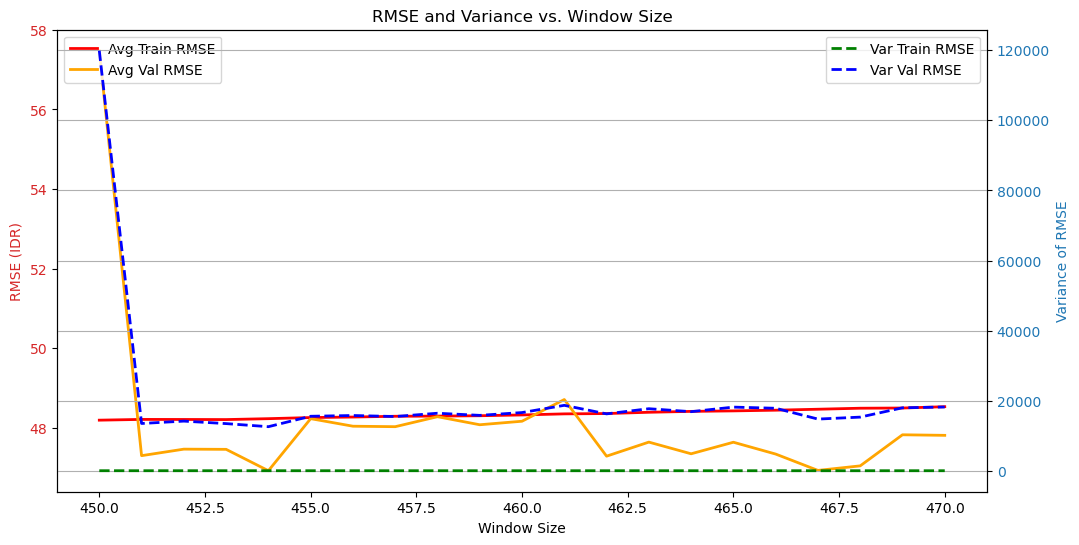

In [98]:
import matplotlib.pyplot as plt

# Ensure you have results_summary populated before running this code
if not results_summary.empty:
    # Plotting RMSE and Variance
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # RMSE Plot
    color = 'tab:red'
    ax1.set_xlabel('Window Size')
    ax1.set_ylabel('RMSE (IDR)', color=color)

    # Plot average RMSE as lines without points
    ax1.plot(results_summary['window_size'].values, results_summary['avg_train_rmse'].values, 
              label='Avg Train RMSE', color='red', linewidth=2)
    ax1.plot(results_summary['window_size'].values, results_summary['avg_val_rmse'].values, 
              label='Avg Val RMSE', color='orange', linewidth=2)

    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    # Create a second y-axis for variance
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Variance of RMSE', color=color)  # Set the label for the second Y axis

    # Plot variance of RMSE as lines without points
    ax2.plot(results_summary['window_size'].values, results_summary['var_train_rmse'].values, 
             label='Var Train RMSE', color='green', linestyle='--', linewidth=2)
    ax2.plot(results_summary['window_size'].values, results_summary['var_val_rmse'].values, 
             label='Var Val RMSE', color='blue', linestyle='--', linewidth=2)

    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title('RMSE and Variance vs. Window Size')
    plt.grid()
    plt.show()
else:
    print("Results summary is empty.")

In [100]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Separate df into features and target
features_df = combined_df.drop(['date', 'next_close'], axis=1)
target_df = combined_df['next_close']
date_df = combined_df['date']

# Convert to NumPy arrays
X = features_df.values
y = target_df.values

# Specify parameters for the sliding window approach
window_size = 453  # Optimal window size
gap = 1            # Step size of each window
num_display = 10    # Number of recent predictions to display

# Lists to store validation and training RMSEs (excluding the last window from avg calculations)
all_val_rmse = []
all_val_rmse_perc = []
all_train_rmse = []
all_train_rmse_perc = []

# Store predictions only for the final days
last_predictions = []

# Number of windows to process
num_windows = len(X) - window_size - 1  # Exclude last row for training

# Loop through each sliding window
window_number = 0
while window_number <= num_windows:
    start = window_number
    end = start + window_size
    X_train = X[start:end]
    y_train = y[start:end]

    # Prepare validation data for prediction
    if end < len(X) - 1:  # Ensure there's data for validation
        X_val = X[end:end + 1]  # Validation is the next row after the current window
        y_val = y[end:end + 1]  # The target for validation
        val_date = date_df.iloc[end:end + 1].values  # Get the date for validation

        # Skip this iteration if y_train contains NaN
        if np.isnan(y_train).any() or np.isnan(y_val).any():
            window_number += gap
            continue

        # Initialize and fit the model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Predict on validation data
        y_pred_val = model.predict(X_val)

        # Calculate RMSE and RMSE percentage for validation
        mse_val = np.mean((y_val - y_pred_val) ** 2)
        rmse_val = np.sqrt(mse_val)
        rmse_val_perc = (rmse_val / y_val)[0] * 100  # Convert to percentage

        # Calculate RMSE for training
        y_pred_train = model.predict(X_train)
        mse_train = np.mean((y_train - y_pred_train) ** 2)
        rmse_train = np.sqrt(mse_train)
        rmse_train_perc = (rmse_train / y_train).mean() * 100  # Convert to percentage

        # Append RMSEs and percentage errors, excluding the last window from averages
        if end < len(X) - 1:  # Only add if it's not the last window
            all_val_rmse.append(rmse_val)
            all_val_rmse_perc.append(rmse_val_perc)
            all_train_rmse.append(rmse_train)
            all_train_rmse_perc.append(rmse_train_perc)

        # Check if we're in the last 3 windows to display
        if end >= len(X) - num_display:
            # Use the date for the next row as the prediction date
            next_row_date = date_df.iloc[end + 1]
            last_predictions.append((next_row_date, y_val[0], y_pred_val[0]))

    # Move to the next window based on the gap
    window_number += gap

# Use the features of the last row for prediction
if len(X) > 0:
    last_row_features = X[-1].reshape(1, -1)  # Reshape to 2D for prediction
    last_row_pred = model.predict(last_row_features)
    last_row_date = date_df.iloc[-1]

    # Append the last row prediction with the correct date
    last_predictions.append((last_row_date + pd.Timedelta(days=1), np.nan, last_row_pred[0]))

# Print the most recent predictions and actual values for the last three days
print("\nRecent Predictions and Actual Values:")
for i, (date, actual, pred) in enumerate(reversed(last_predictions)):
    if np.isnan(actual):
        print(f"Date: {date.date()}, Prediction: {pred:.0f}")
    else:
        error = abs(actual - pred)  # Calculate the absolute error
        error_perc = ((pred/actual)-1)*100
        print(f"Date: {date.date()}, Prediction: {pred:.0f}, Actual: {actual:.0f},  Error: {error:.0f}, Error %: {error_perc:.2f}%")


Recent Predictions and Actual Values:
Date: 2024-10-24, Prediction: 15670
Date: 2024-10-23, Prediction: 15541, Actual: 15586,  Error: 45, Error %: -0.29%
Date: 2024-10-22, Prediction: 15522, Actual: 15556,  Error: 34, Error %: -0.22%
Date: 2024-10-21, Prediction: 15449, Actual: 15467,  Error: 18, Error %: -0.11%
Date: 2024-10-18, Prediction: 15553, Actual: 15493,  Error: 60, Error %: 0.39%
Date: 2024-10-17, Prediction: 15521, Actual: 15584,  Error: 63, Error %: -0.40%
Date: 2024-10-16, Prediction: 15565, Actual: 15579,  Error: 14, Error %: -0.09%
Date: 2024-10-15, Prediction: 15563, Actual: 15573,  Error: 10, Error %: -0.07%
Date: 2024-10-14, Prediction: 15590, Actual: 15562,  Error: 28, Error %: 0.18%
Date: 2024-10-11, Prediction: 15728, Actual: 15671,  Error: 57, Error %: 0.36%


# USD/IDR + (S&P500 + IHSG + USDT/IDRT)

## Fetching Yahoo Finance Data (USD/IDR, USD/JPY, S&P500, IHSG)

In [2]:
import yfinance as yf
import datetime

# Define the tickers and custom DataFrame names
tickers = ["USDIDR=X", "USDJPY=X", "^GSPC", "^JKSE"] # ^GSPC (S&P500), ^JKSE (IHSG)
df_names = ["usd_idr_df", "usd_jpy_df", "snp500_df", "ihsg_df"]

# Define the data interval and time range
interval = '1d'  # Change to '1h' for hourly data
start_date = "2019-10-01"
end_date = datetime.datetime.today().strftime('%Y-%m-%d')  # Get today's date

# Initialize an empty dictionary to store DataFrames with custom names
dataframes = {}

# Download the data for each ticker and assign to the dictionary with the specified names
for ticker, name in zip(tickers, df_names):
    df = yf.download(ticker, start=start_date, end=end_date, interval=interval).reset_index()

    # Rename columns and select specific columns
    df.columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
    df = df[['date', 'open', 'high', 'low', 'close', 'volume']]

    # Assign the DataFrame to the specified name in the dictionary
    dataframes[name] = df

# Access each DataFrame by the custom names
usd_idr_df = dataframes["usd_idr_df"]
usd_jpy_df = dataframes["usd_jpy_df"]
snp500_df = dataframes["snp500_df"]
ihsg_df = dataframes["ihsg_df"]

print("USD/IDR DataFrame:\n", usd_idr_df.size)
print("USD/JPY DataFrame:\n", usd_jpy_df.size)
print("S&P 500 DataFrame:\n", snp500_df.size)
print("IHSG DataFrame:\n", ihsg_df.size)

print("Yahoo Data Fetched Successfully!")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

USD/IDR DataFrame:
 8004
USD/JPY DataFrame:
 8004
S&P 500 DataFrame:
 7722
IHSG DataFrame:
 7446
Yahoo Data Fetched Successfully!


## Fetching Binance data (USDT/IDRT)

In [2]:
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime
from urllib.parse import urlencode
import time

BINANCE_CANDLE_COLUMNS = ['opentime', 'openprice', 'highprice', 'lowprice', 'closeprice', 'volume', 'closetime',
                          'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused']

DATE_FORMAT = "%Y-%m-%d %H:%M:%S"

def binance_recursive_fetch_2(coins, interval, starttime, endtime):
    all_coins_result = {}
    data_list = []
    call_dict = {}
    for coin in tqdm(coins):
        result_list = []
        current_time = starttime
        call = 0
        timestamps = []
        while current_time < endtime:
            # Determine the limit
            if ((int((endtime - current_time)/(1000*60))) + 1) >= 1000:
                limit = 1000
            else:
                limit = int((endtime - current_time)/(1000*60) + 1)
                
            # Construct the URL using urlencode for cleaner handling of parameters
            params = {
                'symbol': f'{coin}',
                'startTime': str(current_time),
                'interval': interval,
                'limit': str(limit)
            }
            url = f'https://api.binance.com/api/v1/klines?{urlencode(params)}'
            
            try:
                response = requests.get(url)
                response.raise_for_status()  # Raise an exception for HTTP errors
                result_list += response.json()
            except requests.exceptions.RequestException as e:
                print(f"Error fetching data for {coin}: {e}")
                break  # Stop the loop if there is an error
            
            # Update current time to the next interval's start time
            current_time = result_list[-1][0] + 60000
            timestamps.append(current_time)
            call += 1
            print(f"{datetime.fromtimestamp(current_time / 1000).strftime(DATE_FORMAT)} - status: {current_time < endtime}, time: {current_time}, limit: {call * 2}")
            
            # Throttle requests to avoid hitting rate limits
            if (call % 60) == 0:
                print('Call reaches 60, waiting for 60 seconds')
                time.sleep(60)  # Wait to avoid rate-limiting
            if timestamps.count(current_time) > 1:
                break  # Break if there's duplicate timestamp (indicating an error)
        
        current_df = pd.DataFrame(result_list, columns=BINANCE_CANDLE_COLUMNS)
        current_df['coin'] = coin
        current_df = current_df[['coin'] + BINANCE_CANDLE_COLUMNS]
        current_df = np.matrix(current_df).tolist()
        data_list += current_df
        call_dict.update({coin: call})
    
    return {'data': np.matrix(data_list).tolist(), 'call': call_dict}

In [3]:
# Convert to datetime and format with time set to midnight
formatted_start_date = datetime.strptime(start_date, "%Y-%m-%d").strftime("%Y-%m-%d %H:%M")
formatted_end_date = datetime.strptime(end_date, "%Y-%m-%d").strftime("%Y-%m-%d %H:%M")

sample = binance_recursive_fetch_2(
    ['USDTIDRT'],  # List of trading pairs
    '1m',  # Interval
    starttime=int(pd.to_datetime(formatted_start_date, utc=True).timestamp() * 1000),
    endtime=int(pd.to_datetime(formatted_end_date, utc=True).timestamp() * 1000)
)

print("Binance Data Fetched Successfully!")

  0%|          | 0/1 [00:00<?, ?it/s]

2020-04-17 20:40:00 - status: True, time: 1587156000000, limit: 2
2020-04-18 13:20:00 - status: True, time: 1587216000000, limit: 4
2020-04-19 06:00:00 - status: True, time: 1587276000000, limit: 6
2020-04-19 22:40:00 - status: True, time: 1587336000000, limit: 8
2020-04-20 15:20:00 - status: True, time: 1587396000000, limit: 10
2020-04-21 08:00:00 - status: True, time: 1587456000000, limit: 12
2020-04-22 00:40:00 - status: True, time: 1587516000000, limit: 14
2020-04-22 17:20:00 - status: True, time: 1587576000000, limit: 16
2020-04-23 10:00:00 - status: True, time: 1587636000000, limit: 18
2020-04-24 02:40:00 - status: True, time: 1587696000000, limit: 20
2020-04-24 19:20:00 - status: True, time: 1587756000000, limit: 22
2020-04-25 14:30:00 - status: True, time: 1587825000000, limit: 24
2020-04-26 07:10:00 - status: True, time: 1587885000000, limit: 26
2020-04-26 23:50:00 - status: True, time: 1587945000000, limit: 28
2020-04-27 16:30:00 - status: True, time: 1588005000000, limit: 30

  0%|          | 0/1 [01:27<?, ?it/s]


KeyboardInterrupt: 

## Process and Features Engineering

### USD/IDR

In [2]:
usd_idr_df

,date,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,14219.400391,14219.400391,14241.500000,14160.299805,0
1,2019-10-02 00:00:00+00:00,14206.000000,14206.000000,14265.099609,14179.900391,0
2,2019-10-03 00:00:00+00:00,14188.000000,14188.000000,14247.700195,14135.400391,0
3,2019-10-04 00:00:00+00:00,14166.000000,14166.000000,14195.000000,14112.000000,0
4,2019-10-07 00:00:00+00:00,14128.000000,14128.000000,14181.500000,14128.000000,0
...,...,...,...,...,...,...
1329,2024-11-04 00:00:00+00:00,15842.000000,15842.000000,15842.000000,15719.000000,0
1330,2024-11-05 00:00:00+00:00,15790.000000,15790.000000,15791.900391,15707.700195,0
1331,2024-11-06 00:00:00+00:00,15665.000000,15665.000000,15883.099609,14476.500000,0
1332,2024-11-07 00:00:00+00:00,15818.200195,15818.200195,15833.799805,15575.000000,0


In [3]:
# Change the date format to 'YYYY-MM-DD'
usd_idr_df['date'] = usd_idr_df['date'].dt.strftime('%Y-%m-%d')

# Drop the 'volume' column
usd_idr_df.drop(columns=['volume'], inplace=True)

# Display the updated DataFrame
usd_idr_df

,date,open,high,low,close
0,2019-10-01,14219.400391,14219.400391,14241.500000,14160.299805
1,2019-10-02,14206.000000,14206.000000,14265.099609,14179.900391
2,2019-10-03,14188.000000,14188.000000,14247.700195,14135.400391
3,2019-10-04,14166.000000,14166.000000,14195.000000,14112.000000
4,2019-10-07,14128.000000,14128.000000,14181.500000,14128.000000
...,...,...,...,...,...
1329,2024-11-04,15842.000000,15842.000000,15842.000000,15719.000000
1330,2024-11-05,15790.000000,15790.000000,15791.900391,15707.700195
1331,2024-11-06,15665.000000,15665.000000,15883.099609,14476.500000
1332,2024-11-07,15818.200195,15818.200195,15833.799805,15575.000000


In [4]:
# # Copy the df
# df_feature = usd_idr_df.copy()

# # Ensure 'date' is consistently used as a datetime format
# df_feature['date'] = pd.to_datetime(df_feature['date'])

# # Features Engineering

# # Create the next_close column as the target variable to be predicted
# df_feature['next_close'] = df_feature['close'].shift(-1)

# # Count the next day gap
# df_feature['gap_day'] = df_feature['date'].shift(-1) - df_feature['date']
# # Convert gap_day to just the number of days and make it an integer
# df_feature['gap_day'] = df_feature['gap_day'].dt.days.fillna(0).astype(int)

# # Calculate the changes from the previous row for OHLC
# df_feature['open_change'] = df_feature['open'].diff()
# df_feature['high_change'] = df_feature['high'].diff()
# df_feature['low_change'] = df_feature['low'].diff()
# df_feature['close_change'] = df_feature['close'].diff()

# # Function to calculate moving average over a custom date range
# def custom_moving_average(df, close_col, date_col, days):
#     averages = []
#     for index, row in df.iterrows():
#         current_date = row[date_col]
#         # Get the date range
#         start_date = current_date - pd.Timedelta(days=days)
#         # Filter the DataFrame for the desired date range
#         mask = (df[date_col] >= start_date) & (df[date_col] <= current_date)
#         # Calculate the mean for the filtered values
#         avg = df.loc[mask, close_col].mean()
#         averages.append(avg)
#     return averages

# # Calculate the custom moving averages
# df_feature['ma_close_5'] = custom_moving_average(df_feature, 'close', 'date', days=4)  # 4 previous days + today
# df_feature['ma_close_10'] = custom_moving_average(df_feature, 'close', 'date', days=9)  # 9 previous days + today

# # Capture previous values
# df_feature['prev_open'] = df_feature['open'].shift(1)
# df_feature['prev_high'] = df_feature['high'].shift(1)
# df_feature['prev_low'] = df_feature['low'].shift(1)
# df_feature['prev_close'] = df_feature['close'].shift(1)

# # Add daily range (high-low)
# df_feature['daily_range'] = df_feature['high'] - df_feature['low']

# # Add gap change (today's open - previous close)
# df_feature['gap_change'] = df_feature['open'] - df_feature['prev_close']

# # Add close-to-moving average ratios
# df_feature['close_ma5_ratio'] = df_feature['close'] / df_feature['ma_close_5']
# df_feature['close_ma10_ratio'] = df_feature['close'] / df_feature['ma_close_10']

# # Drop columns that are not needed for prediction
# df_feature = df_feature[['date', 'open', 'high', 'low', 'close', 'gap_day', 
#          'next_close', 'open_change', 'high_change', 
#          'low_change', 'close_change', 'ma_close_5', 
#          'ma_close_10', 'prev_open', 'prev_high', 
#          'prev_low', 'prev_close', 'daily_range', 'gap_change',
#          'close_ma5_ratio', 'close_ma10_ratio']]

# # Others Features Engineering
# df_feature['open_change_perc'] = df_feature['open_change'] / df_feature['prev_open']
# df_feature['high_change_perc'] = df_feature['high_change'] / df_feature['prev_high']
# df_feature['low_change_perc'] = df_feature['low_change'] / df_feature['prev_low']
# df_feature['close_change_perc'] = df_feature['close_change'] / df_feature['prev_close']

# df_feature['prev_daily_range'] = df_feature['prev_high'] - df_feature['prev_low']
# df_feature['daily_range_change'] = df_feature['daily_range'] - df_feature['prev_daily_range']

# df_feature['open_prev_close_change'] = df_feature['open'] - df_feature['prev_close']

# df_feature['volatility'] = ((df_feature['high'] - df_feature['low']) / df_feature['open']) * 100
# df_feature['prev_volatility'] = ((df_feature['prev_high'] - df_feature['prev_low']) / df_feature['prev_open']) * 100
# df_feature['volatility_change'] = df_feature['volatility'] - df_feature['prev_volatility']

# # Filter the DataFrame to include only rows from the year onwards
# df_feature = df_feature[df_feature['date'] >= '2015-01-01']

# df_feature

### USD/JPY

In [5]:
usd_jpy_df

,date,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,108.069000,108.069000,108.447998,107.669998,0
1,2019-10-02 00:00:00+00:00,107.737000,107.737000,107.884003,107.183998,0
2,2019-10-03 00:00:00+00:00,107.163002,107.163002,107.291000,106.505997,0
3,2019-10-04 00:00:00+00:00,106.825996,106.825996,107.113998,106.656998,0
4,2019-10-07 00:00:00+00:00,106.764000,106.764000,107.068001,106.689003,0
...,...,...,...,...,...,...
1329,2024-11-04 00:00:00+00:00,152.287003,152.287003,152.285004,151.550995,0
1330,2024-11-05 00:00:00+00:00,152.276001,152.276001,152.531006,151.796005,0
1331,2024-11-06 00:00:00+00:00,151.434998,151.434998,154.649994,151.343002,0
1332,2024-11-07 00:00:00+00:00,154.320007,154.320007,154.701996,152.860992,0


In [4]:
# Change the date format to 'YYYY-MM-DD'
usd_jpy_df['date'] = usd_jpy_df['date'].dt.strftime('%Y-%m-%d')

# Drop the 'volume' column
usd_jpy_df.drop(columns=['volume'], inplace=True)

usd_jpy_df.rename(columns={ 
    'open': 'jpy_open', 
    'high': 'jpy_high',
    'low': 'jpy_low', 
    'close': 'jpy_close'
}, inplace=True)

# Display the updated DataFrame
usd_jpy_df

,date,jpy_open,jpy_high,jpy_low,jpy_close
0,2019-10-01,108.069000,108.069000,108.447998,107.669998
1,2019-10-02,107.737000,107.737000,107.884003,107.183998
2,2019-10-03,107.163002,107.163002,107.291000,106.505997
3,2019-10-04,106.825996,106.825996,107.113998,106.656998
4,2019-10-07,106.764000,106.764000,107.068001,106.689003
...,...,...,...,...,...
1329,2024-11-04,152.287003,152.287003,152.285004,151.550995
1330,2024-11-05,152.276001,152.276001,152.531006,151.796005
1331,2024-11-06,151.434998,151.434998,154.649994,151.343002
1332,2024-11-07,154.320007,154.320007,154.701996,152.860992


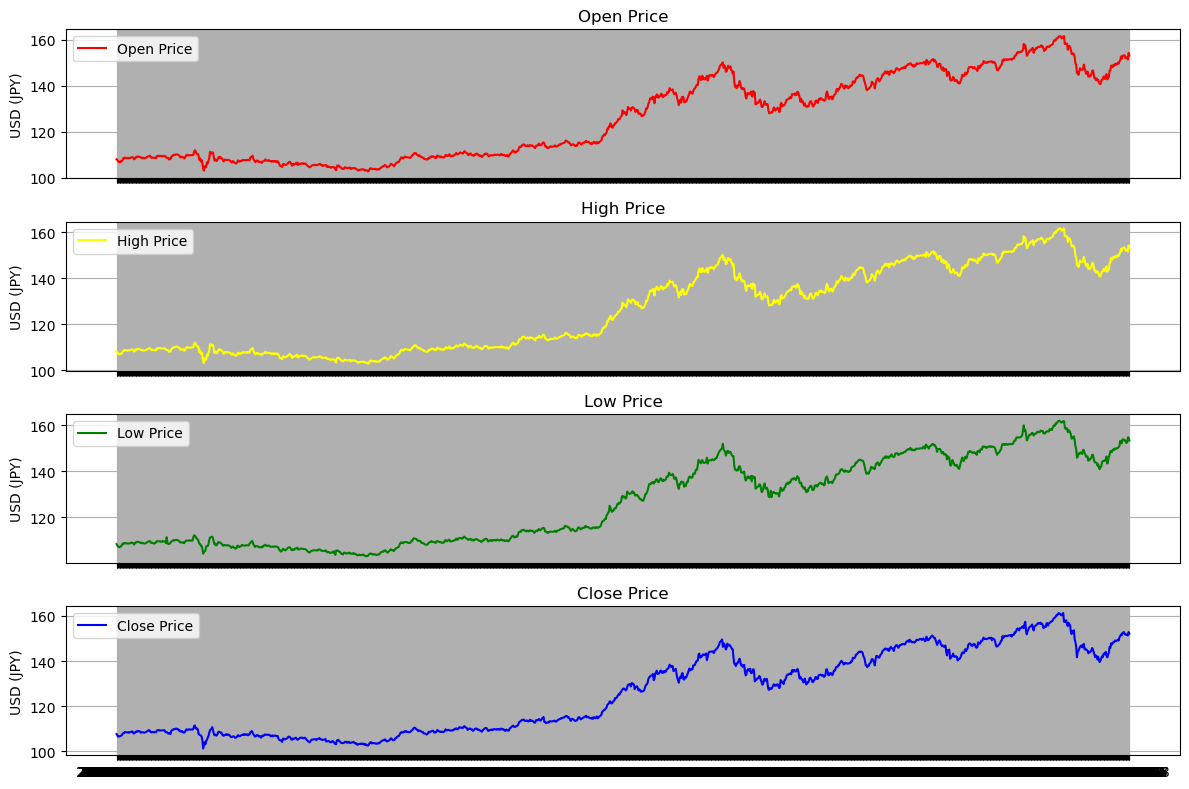

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert columns to NumPy arrays
dates = np.array(usd_jpy_df['date'])
open_prices = np.array(usd_jpy_df['open'])
high_prices = np.array(usd_jpy_df['high'])
low_prices = np.array(usd_jpy_df['low'])
close_prices = np.array(usd_jpy_df['close'])

# Plotting
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# Plotting the 'open' prices
ax1.plot(dates, open_prices, color='red', label='Open Price')
ax1.set_title('Open Price')
ax1.set_ylabel('USD (JPY)')
ax1.legend()
ax1.grid(True)

# Plotting the 'highi' prices
ax2.plot(dates, high_prices, color='yellow', label='High Price')
ax2.set_title('High Price')
ax2.set_ylabel('USD (JPY)')
ax2.legend()
ax2.grid(True)

# Plotting the 'low' prices
ax3.plot(dates, low_prices, color='green', label='Low Price')
ax3.set_title('Low Price')
ax3.set_ylabel('USD (JPY)')
ax3.legend()
ax3.grid(True)

# Plotting the 'close' prices
ax4.plot(dates, close_prices, color='blue', label='Close Price')
ax4.set_title('Close Price')
ax4.set_ylabel('USD (JPY)')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

### S&P500

In [7]:
snp500_df

,date,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,2940.250000,2940.250000,2992.530029,2938.699951,3560750000
1,2019-10-02 00:00:00+00:00,2887.610107,2887.610107,2924.780029,2874.929932,3914180000
2,2019-10-03 00:00:00+00:00,2910.629883,2910.629883,2911.129883,2855.939941,3515130000
3,2019-10-04 00:00:00+00:00,2952.010010,2952.010010,2953.739990,2918.560059,3005600000
4,2019-10-07 00:00:00+00:00,2938.790039,2938.790039,2959.750000,2935.679932,2959050000
...,...,...,...,...,...,...
1282,2024-11-04 00:00:00+00:00,5712.689941,5712.689941,5741.430176,5696.509766,3602060000
1283,2024-11-05 00:00:00+00:00,5782.759766,5782.759766,5783.439941,5722.100098,3768310000
1284,2024-11-06 00:00:00+00:00,5929.040039,5929.040039,5936.140137,5864.890137,6329530000
1285,2024-11-07 00:00:00+00:00,5973.100098,5973.100098,5983.839844,5947.209961,4925740000


In [5]:
# Change the date format to 'YYYY-MM-DD'
snp500_df['date'] = snp500_df['date'].dt.strftime('%Y-%m-%d')

# Drop unused column
snp500_df.drop(columns=['open','high','low'], inplace=True)

snp500_df.rename(columns={ 
    'close': 'snp500_close', 
    'volume': 'snp500_volume'
}, inplace=True)

snp500_df

,date,snp500_close,snp500_volume
0,2019-10-01,2938.699951,3560750000
1,2019-10-02,2874.929932,3914180000
2,2019-10-03,2855.939941,3515130000
3,2019-10-04,2918.560059,3005600000
4,2019-10-07,2935.679932,2959050000
...,...,...,...
1282,2024-11-04,5696.509766,3602060000
1283,2024-11-05,5722.100098,3768310000
1284,2024-11-06,5864.890137,6329530000
1285,2024-11-07,5947.209961,4925740000


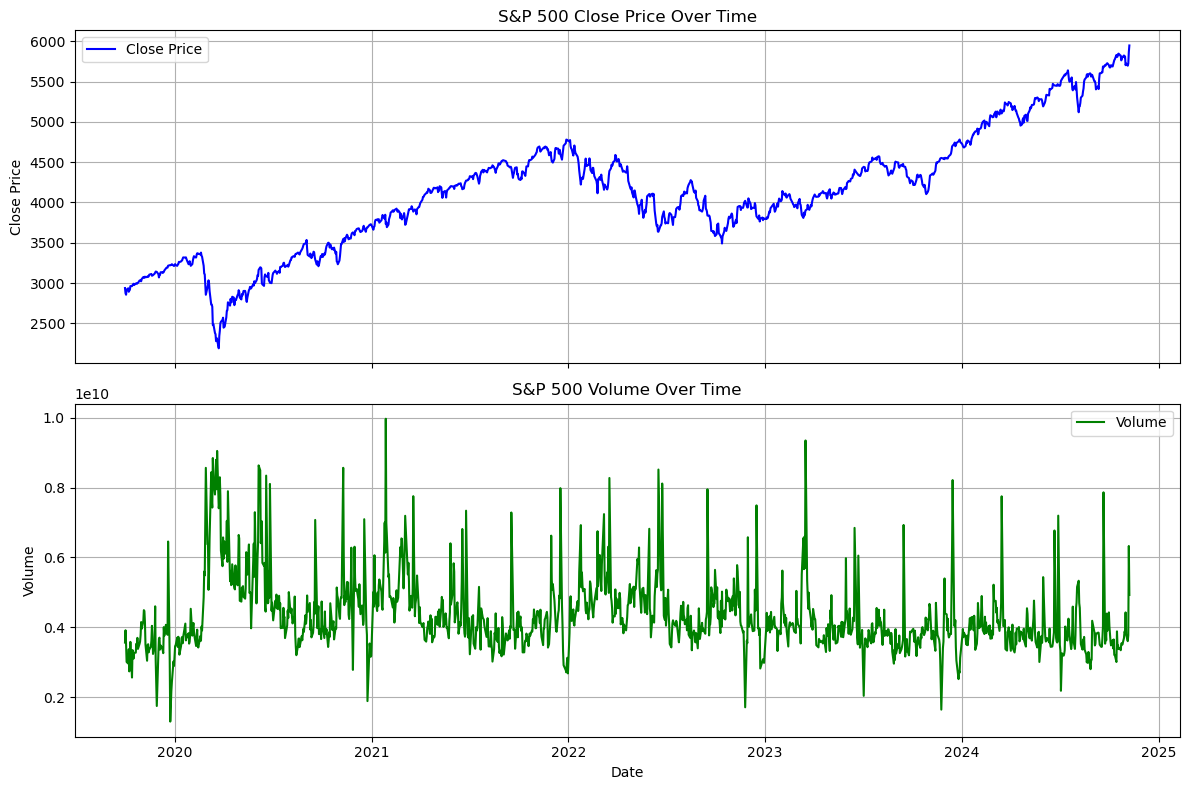

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert columns to NumPy arrays
dates = np.array(snp500_df['date'])
close_prices = np.array(snp500_df['close'])
volumes = np.array(snp500_df['volume'])

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plotting the 'close' prices
ax1.plot(dates, close_prices, color='blue', label='Close Price')
ax1.set_title('S&P 500 Close Price Over Time')
ax1.set_ylabel('Close Price')
ax1.legend()
ax1.grid(True)

# Plotting the 'volume'
ax2.plot(dates, volumes, color='green', label='Volume')
ax2.set_title('S&P 500 Volume Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Volume')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [9]:
# # Copy the original DataFrame
# snp500_features = snp500_df.copy()

# # Convert date format to 'YYYY-MM-DD'
# snp500_features['date'] = pd.to_datetime(snp500_features['date']).dt.strftime('%Y-%m-%d')

# # Calculate the current close - previous close as snp_change
# snp500_features['snp_change'] = snp500_features['close'].diff()

# # Calculate snp_change / current close as snp_change_perc
# snp500_features['snp_change_perc'] = snp500_features['snp_change'] / snp500_features['close']

# # Calculate the average snp_change for 5 days and 10 days
# snp500_features['snp_change_avg_5'] = snp500_features['snp_change'].rolling(window=5).mean()
# snp500_features['snp_change_avg_10'] = snp500_features['snp_change'].rolling(window=10).mean()

# # Calculate the average snp_change_perc for 5 days and 10 days
# snp500_features['snp_change_perc_avg_5'] = snp500_features['snp_change_perc'].rolling(window=5).mean()
# snp500_features['snp_change_perc_avg_10'] = snp500_features['snp_change_perc'].rolling(window=10).mean()

# # Calculate the difference between the current close and the close 4 and 9 days ago
# snp500_features['snp_close_diff_4'] = snp500_features['close'] - snp500_features['close'].shift(4)
# snp500_features['snp_close_diff_9'] = snp500_features['close'] - snp500_features['close'].shift(9)

# # Calculate the current volume - previous volume as volume_change
# snp500_features['volume_change'] = snp500_features['volume'].diff()

# # Calculate volume_change / current volume as volume_change_perc
# snp500_features['volume_change_perc'] = snp500_features['volume_change'] / snp500_features['volume']

# # Calculate the average volume_change for 5 days and 10 days
# snp500_features['volume_change_avg_5'] = snp500_features['volume_change'].rolling(window=5).mean()
# snp500_features['volume_change_avg_10'] = snp500_features['volume_change'].rolling(window=10).mean()

# # Calculate the average volume_change_perc for 5 days and 10 days
# snp500_features['volume_change_perc_avg_5'] = snp500_features['volume_change_perc'].rolling(window=5).mean()
# snp500_features['volume_change_perc_avg_10'] = snp500_features['volume_change_perc'].rolling(window=10).mean()

# # Calculate the difference between the current volume and the volume 4 and 9 days ago
# snp500_features['volume_diff_4'] = snp500_features['volume'] - snp500_features['volume'].shift(4)
# snp500_features['volume_diff_9'] = snp500_features['volume'] - snp500_features['volume'].shift(9)

# # Drop the 'open', 'high', and 'low' columns
# snp500_features.drop(columns=['open', 'high', 'low'], inplace=True)

# # Drop Nan row
# snp500_features.dropna(inplace=True)

# # Display the updated features DataFrame
# snp500_features

In [10]:
# # Check for NaN or None values
# has_nan_or_none = snp500_features.isnull().values.any()

# # Check for inf values in numeric columns only
# has_inf = np.isinf(snp500_features.select_dtypes(include=[np.number])).values.any()

# # Output the result
# print("Contains NaN or None values:", has_nan_or_none)
# print("Contains inf values:", has_inf)

### IHSG

In [11]:
ihsg_df

,date,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,6138.250000,6138.250000,6176.605957,6134.770020,99171900
1,2019-10-02 00:00:00+00:00,6055.424805,6055.424805,6153.996094,6051.687988,116223100
2,2019-10-03 00:00:00+00:00,6038.528809,6038.528809,6050.604004,5997.691895,121133700
3,2019-10-04 00:00:00+00:00,6061.251953,6061.251953,6076.560059,6046.129883,111920200
4,2019-10-07 00:00:00+00:00,6000.582031,6000.582031,6084.165039,5988.872070,127549800
...,...,...,...,...,...,...
1236,2024-11-04 00:00:00+00:00,7479.502930,7479.502930,7529.703125,7415.809082,212287900
1237,2024-11-05 00:00:00+00:00,7491.931152,7491.931152,7496.996094,7451.547852,182653900
1238,2024-11-06 00:00:00+00:00,7383.868164,7383.868164,7506.601074,7363.030762,235788800
1239,2024-11-07 00:00:00+00:00,7243.859863,7243.859863,7381.757812,7243.859863,204087800


In [12]:
# Change the date format to 'YYYY-MM-DD'
ihsg_df['date'] = ihsg_df['date'].dt.strftime('%Y-%m-%d')

# Drop the 'volume' column
ihsg_df.drop(columns=['open','high','low','volume'], inplace=True)

ihsg_df.rename(columns={
    'close': 'ihsg_close' 
}, inplace=True)

ihsg_df

,date,ihsg_close
0,2019-10-01,6134.770020
1,2019-10-02,6051.687988
2,2019-10-03,5997.691895
3,2019-10-04,6046.129883
4,2019-10-07,5988.872070
...,...,...
1236,2024-11-04,7415.809082
1237,2024-11-05,7451.547852
1238,2024-11-06,7363.030762
1239,2024-11-07,7243.859863


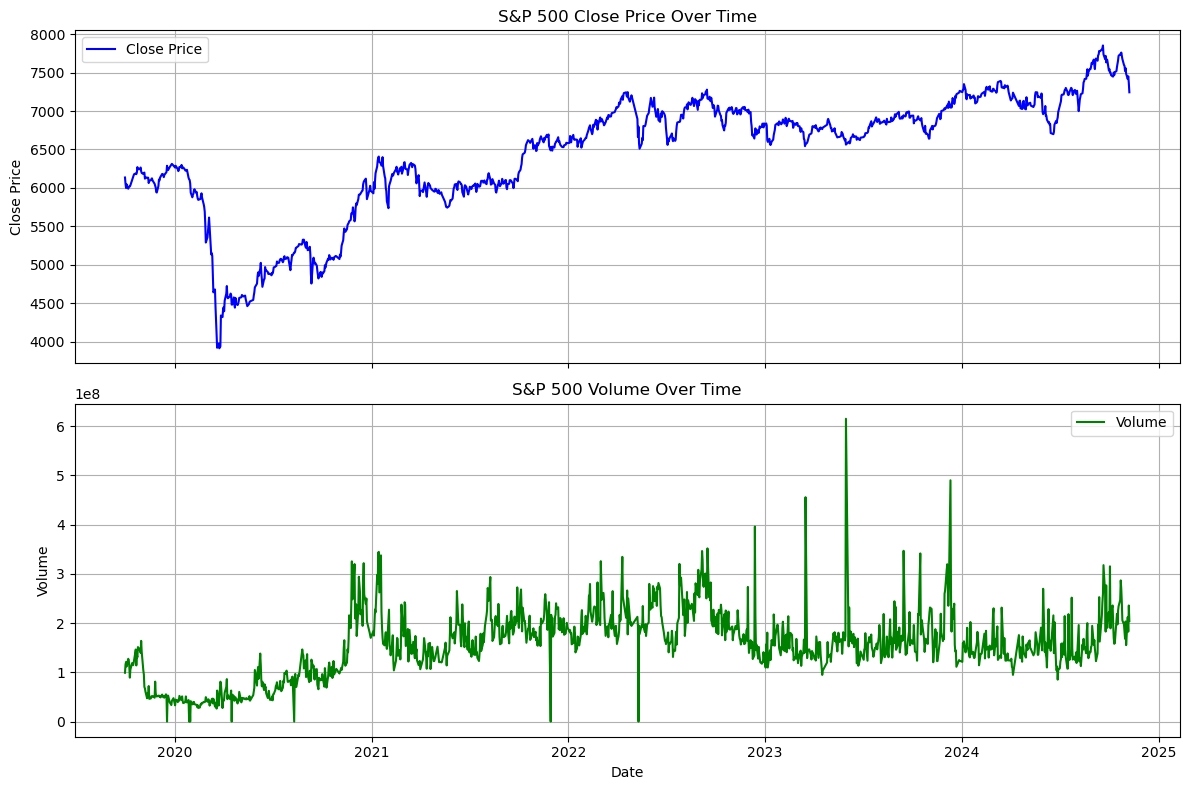

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert columns to NumPy arrays
dates = np.array(ihsg_df['date'])
close_prices = np.array(ihsg_df['close'])
volumes = np.array(ihsg_df['volume'])

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plotting the 'close' prices
ax1.plot(dates, close_prices, color='blue', label='Close Price')
ax1.set_title('S&P 500 Close Price Over Time')
ax1.set_ylabel('Close Price')
ax1.legend()
ax1.grid(True)

# Plotting the 'volume'
ax2.plot(dates, volumes, color='green', label='Volume')
ax2.set_title('S&P 500 Volume Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Volume')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [13]:
# # Step 1: Copy the DataFrame
# ihsg_features = ihsg_df.copy()

# # Step 2: Convert the date format to 'YYYY-MM-DD'
# ihsg_features['date'] = ihsg_features['date'].dt.strftime('%Y-%m-%d')

# # Step 3: Calculate the new features
# # Calculate the current close - previous close as ihsg_change
# ihsg_features['ihsg_change'] = ihsg_features['close'].diff()

# # Calculate ihsg_change / current close as ihsg_change_perc
# ihsg_features['ihsg_change_perc'] = ihsg_features['ihsg_change'] / ihsg_features['close']

# # Calculate the average ihsg_change for 5 and 10 days
# ihsg_features['avg_ihsg_change_5'] = ihsg_features['ihsg_change'].rolling(window=5).mean()
# ihsg_features['avg_ihsg_change_10'] = ihsg_features['ihsg_change'].rolling(window=10).mean()

# # Calculate the average ihsg_change_perc for 5 and 10 days
# ihsg_features['avg_ihsg_change_perc_5'] = ihsg_features['ihsg_change_perc'].rolling(window=5).mean()
# ihsg_features['avg_ihsg_change_perc_10'] = ihsg_features['ihsg_change_perc'].rolling(window=10).mean()

# # Calculate the difference of current close and 4 days ago, also for 9 days ago
# ihsg_features['close_diff_4'] = ihsg_features['close'] - ihsg_features['close'].shift(4)
# ihsg_features['close_diff_9'] = ihsg_features['close'] - ihsg_features['close'].shift(9)

# # Step 4: Drop the 'open', 'high', and 'low' columns
# ihsg_features.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

# # Drop Nan row
# ihsg_features.dropna(inplace=True)

# # Display the updated DataFrame
# ihsg_features

### Combined Yahoo data

In [15]:
import pandas as pd

# Perform an inner join to combine all DataFrames on the 'date' column
combined_yahoo_df = usd_idr_df.merge(usd_jpy_df, on='date', how='inner').merge(snp500_df, on='date', how='inner').merge(ihsg_df, on='date', how='inner')

combined_yahoo_df['date'] = pd.to_datetime(combined_yahoo_df['date'])

# Display the combined DataFrame
combined_yahoo_df

,date,open,high,low,close,jpy_open,jpy_high,jpy_low,jpy_close,snp500_close,snp500_volume,ihsg_close
0,2019-10-01,14219.400391,14219.400391,14241.500000,14160.299805,108.069000,108.069000,108.447998,107.669998,2938.699951,3560750000,6134.770020
1,2019-10-02,14206.000000,14206.000000,14265.099609,14179.900391,107.737000,107.737000,107.884003,107.183998,2874.929932,3914180000,6051.687988
2,2019-10-03,14188.000000,14188.000000,14247.700195,14135.400391,107.163002,107.163002,107.291000,106.505997,2855.939941,3515130000,5997.691895
3,2019-10-04,14166.000000,14166.000000,14195.000000,14112.000000,106.825996,106.825996,107.113998,106.656998,2918.560059,3005600000,6046.129883
4,2019-10-07,14128.000000,14128.000000,14181.500000,14128.000000,106.764000,106.764000,107.068001,106.689003,2935.679932,2959050000,5988.872070
...,...,...,...,...,...,...,...,...,...,...,...,...
1201,2024-11-04,15842.000000,15842.000000,15842.000000,15719.000000,152.287003,152.287003,152.285004,151.550995,5696.509766,3602060000,7415.809082
1202,2024-11-05,15790.000000,15790.000000,15791.900391,15707.700195,152.276001,152.276001,152.531006,151.796005,5722.100098,3768310000,7451.547852
1203,2024-11-06,15665.000000,15665.000000,15883.099609,14476.500000,151.434998,151.434998,154.649994,151.343002,5864.890137,6329530000,7363.030762
1204,2024-11-07,15818.200195,15818.200195,15833.799805,15575.000000,154.320007,154.320007,154.701996,152.860992,5947.209961,4925740000,7243.859863


### USDT/IDRT

In [16]:
import polars as pl
import pandas as pd

# Read parquet file
usdt_idrt = pl.read_parquet("USDT_IDRT.parquet")

# Convert to Pandas DataFrame
usdt_idrt = usdt_idrt.to_pandas()
usdt_idrt

usdt_idrt['opentime'] = pd.to_datetime(usdt_idrt['opentime'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')
usdt_idrt['closetime'] = pd.to_datetime(usdt_idrt['closetime'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')

# Convert 'opentime' and 'closetime' to datetime
usdt_idrt['opentime'] = pd.to_datetime(usdt_idrt['opentime'])
usdt_idrt['closetime'] = pd.to_datetime(usdt_idrt['closetime'])

# Calculate Volume-Weighted Average Price (VWAP)
usdt_idrt['vwap'] = 0  # Default to 0
usdt_idrt.loc[usdt_idrt['volume'] != 0, 'vwap'] = usdt_idrt['quotevolume'] / usdt_idrt['volume']

# Calculate Average Trade Size
usdt_idrt['avg_trade_size'] = 0  # Default to 0
usdt_idrt.loc[usdt_idrt['trades'] != 0, 'avg_trade_size'] = usdt_idrt['volume'] / usdt_idrt['trades']

# Calculate Trade Count Change (difference in trades from previous row)
usdt_idrt['trade_count_change'] = usdt_idrt['trades'].diff()

# Calculate Taker Buy Volume Ratio
usdt_idrt['taker_buy_volume_ratio'] = 0  # Default to 0
usdt_idrt.loc[usdt_idrt['volume'] != 0, 'taker_buy_volume_ratio'] = usdt_idrt['taker_buy_volume'] / usdt_idrt['volume']

# Calculate Taker Buy Quote Ratio
usdt_idrt['taker_buy_quote_ratio'] = 0  # Default to 0
usdt_idrt.loc[usdt_idrt['quotevolume'] != 0, 'taker_buy_quote_ratio'] = usdt_idrt['taker_buy_quote'] / usdt_idrt['quotevolume']

# Calculate Daily Volume Change
usdt_idrt['daily_volume_change'] = usdt_idrt['volume'].diff()

# Calculate Daily Quote Volume Change
usdt_idrt['daily_quote_volume_change'] = usdt_idrt['quotevolume'].diff()

# Calculate Buy/Sell Volume Imbalance
usdt_idrt['buy_sell_volume_imbalance'] = abs(usdt_idrt['taker_buy_volume'] - (usdt_idrt['volume'] - usdt_idrt['taker_buy_volume']))

# Calculate Relative Volume (volume compared to 5-period MA of volume)
usdt_idrt['ma_volume_5'] = usdt_idrt['volume'].rolling(window=5).mean()
usdt_idrt['relative_volume'] = 0  # Default to 0
usdt_idrt.loc[usdt_idrt['ma_volume_5'] != 0, 'relative_volume'] = usdt_idrt['volume'] / usdt_idrt['ma_volume_5']

# Calculate Volume Volatility (standard deviation of volume over a rolling window)
usdt_idrt['volume_volatility'] = usdt_idrt['volume'].rolling(window=5).std()

# Volume Spike Indicator (1 if volume > 1.5 times the 5-period moving average, else 0)
usdt_idrt['volume_spike'] = (usdt_idrt['volume'] > 1.5 * usdt_idrt['ma_volume_5']).astype(int)

# Calculate Price-to-Volume Ratio
usdt_idrt['price_to_volume_ratio'] = 0  # Default to 0
usdt_idrt.loc[usdt_idrt['volume'] != 0, 'price_to_volume_ratio'] = usdt_idrt['closeprice'] / usdt_idrt['volume']

# Calculate Trade Frequency per Minute (assuming 1-minute intervals in the data)
usdt_idrt['trades_per_minute'] = usdt_idrt['trades']  # Assuming this is valid as it is

# Calculate Taker Buy Volume Change
usdt_idrt['taker_buy_volume_change'] = usdt_idrt['taker_buy_volume'].diff()

# Drop the intermediate 'ma_volume_5' column if it is no longer needed
usdt_idrt = usdt_idrt.drop(columns=['ma_volume_5'])

# Calculate duration in minutes
usdt_idrt['duration_minutes'] = (usdt_idrt['closetime'] - usdt_idrt['opentime']).dt.total_seconds() / 60

# Drop rows with NaN values
usdt_idrt = usdt_idrt.dropna()

# First, make sure 'opentime' is set as the DataFrame index or create a 'date' column.
usdt_idrt['date'] = usdt_idrt['opentime'].dt.date

# Group by date and aggregate features
usdt_idrt = usdt_idrt.groupby('date').agg({
    'openprice': 'first',
    'highprice': 'max',
    'lowprice': 'min',
    'closeprice': 'last',
    'volume': 'sum',
    'quotevolume': 'sum',
    'vwap': 'mean',
    'avg_trade_size': 'mean',
    'trade_count_change': 'mean',
    'taker_buy_volume_ratio': 'mean',
    'daily_volume_change': 'mean',  # You might want to sum or calculate the mean
    'buy_sell_volume_imbalance': 'mean',
    'relative_volume': 'mean',
    'volume_volatility': 'mean',
    'volume_spike': 'sum',  # Count the number of spikes
    'price_to_volume_ratio': 'mean',
    'trades_per_minute': 'sum',  # Total number of trades
    'taker_buy_volume_change': 'mean'
}).reset_index()

# Optionally, you can rename the columns for clarity
usdt_idrt.columns = ['date', 't_daily_open', 't_daily_high', 't_daily_low', 't_daily_close', 
                     't_total_volume', 't_total_quote_volume', 't_avg_vwap', 't_avg_trade_size',
                     't_avg_trade_count_change', 't_avg_taker_buy_volume_ratio', 
                     't_daily_volume_change', 't_avg_buy_sell_volume_imbalance', 
                     't_avg_relative_volume', 't_avg_volume_volatility', 
                     't_count_volume_spikes', 't_avg_price_to_volume_ratio', 
                     't_total_trades', 't_avg_taker_buy_volume_change']

usdt_idrt['date'] = pd.to_datetime(usdt_idrt['date'])

# Display the aggregated DataFrame
usdt_idrt

/tmp/ipykernel_202411/781124937.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3766.46045476  5272.37658019 14092.81954537 ... 15692.
 15691.         15693.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  usdt_idrt.loc[usdt_idrt['volume'] != 0, 'vwap'] = usdt_idrt['quotevolume'] / usdt_idrt['volume']
/tmp/ipykernel_202411/781124937.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[175.91666667  50.62666667 132.16192308 ...   3.           5.
   5.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  usdt_idrt.loc[usdt_idrt['trades'] != 0, 'avg_trade_size'] = usdt_idrt['volume'] / usdt_idrt['trades']
/tmp/ipykernel_202411/781124937.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of

,date,t_daily_open,t_daily_high,t_daily_low,t_daily_close,t_total_volume,t_total_quote_volume,t_avg_vwap,t_avg_trade_size,t_avg_trade_count_change,t_avg_taker_buy_volume_ratio,t_daily_volume_change,t_avg_buy_sell_volume_imbalance,t_avg_relative_volume,t_avg_volume_volatility,t_count_volume_spikes,t_avg_price_to_volume_ratio,t_total_trades,t_avg_taker_buy_volume_change
0,2020-04-17,13662.0,16000.0,3123.0,15503.0,117773.22,1.745741e+09,4184.960047,16.010277,-0.016722,0.110303,-1.677977e+00,69.929916,0.634691,109.439210,176,676.275536,1673,-1.814381e-02
1,2020-04-18,15503.0,15690.0,15367.0,15367.0,13578.59,2.114804e+08,1576.090429,5.127961,0.000000,0.020952,0.000000e+00,8.901229,0.351330,17.100600,110,210.212877,282,0.000000e+00
2,2020-04-19,15367.0,15698.0,15367.0,15415.0,7616.11,1.184481e+08,1512.133770,2.620806,0.000000,0.020575,0.000000e+00,5.084688,0.264288,8.442812,77,169.595275,283,0.000000e+00
3,2020-04-20,15421.0,15899.0,15410.0,15485.0,14347.61,2.231153e+08,929.999932,4.010586,0.000000,0.027481,3.947460e-17,8.322229,0.248679,19.744689,76,59.723809,185,0.000000e+00
4,2020-04-21,15485.0,15993.0,15440.0,15911.0,9698.54,1.517452e+08,750.737316,2.446892,0.001389,0.021210,1.503472e-02,6.272625,0.181492,13.008142,56,375.955912,161,-7.894919e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646,2024-10-19,15528.0,15528.0,15500.0,15501.0,252320.00,3.915541e+09,3296.820128,92.211597,0.000000,0.098023,0.000000e+00,173.206944,0.618322,359.345575,197,327.005326,422,0.000000e+00
1647,2024-10-20,15501.0,15525.0,15480.0,15481.0,210107.00,3.256743e+09,3477.544491,85.363461,0.000694,0.096772,9.722222e-03,145.156250,0.657541,301.288598,211,350.624188,444,9.722222e-03
1648,2024-10-21,15481.0,15580.0,15425.0,15573.0,683269.00,1.060203e+10,4052.405508,219.996603,-0.000694,0.145055,-9.722222e-03,471.202083,0.707283,847.127105,235,363.594107,575,-9.722222e-03
1649,2024-10-22,15573.0,15630.0,15556.0,15602.0,676648.00,1.056665e+10,4475.066185,265.101246,0.000000,0.159303,0.000000e+00,463.681944,0.752574,775.014637,251,371.860695,624,0.000000e+00


### All data combined

In [17]:
# Perform an inner join to combine all DataFrames on the 'date' column
combined_df = combined_yahoo_df.merge(usdt_idrt, on='date', how='inner')

combined_df

,date,open,high,low,close,jpy_open,jpy_high,jpy_low,jpy_close,snp500_close,...,t_avg_trade_count_change,t_avg_taker_buy_volume_ratio,t_daily_volume_change,t_avg_buy_sell_volume_imbalance,t_avg_relative_volume,t_avg_volume_volatility,t_count_volume_spikes,t_avg_price_to_volume_ratio,t_total_trades,t_avg_taker_buy_volume_change
0,2020-04-17,15568.338867,15568.338867,15821.000000,15383.200195,107.945000,107.945000,107.943001,107.306000,2830.879883,...,-0.016722,0.110303,-1.677977e+00,69.929916,0.634691,109.439210,176,676.275536,1673,-1.814381e-02
1,2020-04-20,15423.000000,15423.000000,15662.000000,15172.310547,107.669998,107.669998,107.945999,107.601997,2820.429932,...,0.000000,0.027481,3.947460e-17,8.322229,0.248679,19.744689,76,59.723809,185,0.000000e+00
2,2020-04-21,15377.080078,15377.080078,15712.000000,15375.480469,107.668999,107.668999,107.811996,107.295998,2727.100098,...,0.001389,0.021210,1.503472e-02,6.272625,0.181492,13.008142,56,375.955912,161,-7.894919e-17
3,2020-04-22,15394.678711,15394.678711,15875.500000,15388.157227,107.721001,107.721001,107.931000,107.526001,2775.949951,...,-0.001389,0.032471,-1.503472e-02,8.585583,0.211022,14.075487,70,1207.294007,245,0.000000e+00
4,2020-04-23,15408.622070,15408.622070,15770.500000,15416.747070,107.813004,107.813004,107.970001,107.349998,2794.260010,...,0.000000,0.022613,0.000000e+00,5.771007,0.234193,12.386822,72,104.777833,167,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,2024-10-17,15583.900391,15583.900391,15587.000000,15482.200195,149.576004,149.576004,150.138000,149.257004,5840.250000,...,0.000000,0.126234,0.000000e+00,215.487500,0.683476,411.610757,224,369.047109,481,0.000000e+00
1056,2024-10-18,15493.000000,15493.000000,15525.000000,15441.000000,150.100006,150.100006,150.139008,149.514999,5846.109863,...,0.000000,0.120413,0.000000e+00,263.111806,0.693075,533.496789,224,336.767923,537,0.000000e+00
1057,2024-10-21,15467.000000,15467.000000,15544.200195,15421.000000,149.600006,149.600006,150.487000,149.095993,5824.790039,...,-0.000694,0.145055,-9.722222e-03,471.202083,0.707283,847.127105,235,363.594107,575,-9.722222e-03
1058,2024-10-22,15556.000000,15556.000000,15575.700195,15515.000000,150.604996,150.604996,151.128998,150.518005,5821.169922,...,0.000000,0.159303,0.000000e+00,463.681944,0.752574,775.014637,251,371.860695,624,0.000000e+00


In [ ]:
import pandas as pd

# combined_df_features = combined_df.copy()
combined_df_features = combined_yahoo_df.copy()

# Convert date format to 'YYYY-MM-DD'
combined_df_features['date'] = pd.to_datetime(combined_df_features['date']).dt.strftime('%Y-%m-%d')

# ------------------- Initial General Features -------------------

# Create the next_close column as the target variable to be predicted
combined_df_features['next_close'] = combined_df_features['close'].shift(-1)

# Convert 'date' column to datetime format before performing operations
combined_df_features['date'] = pd.to_datetime(combined_df_features['date'], errors='coerce')

# Recalculate 'gap_day' after converting 'date' to datetime
combined_df_features['gap_day'] = (combined_df_features['date'].shift(-1) - combined_df_features['date']).dt.days.fillna(0).astype(int)

# Calculate the changes from the previous row for OHLC
combined_df_features['open_change'] = combined_df_features['open'].diff()
combined_df_features['high_change'] = combined_df_features['high'].diff()
combined_df_features['low_change'] = combined_df_features['low'].diff()
combined_df_features['close_change'] = combined_df_features['close'].diff()

# Calculate the moving averages using a standard rolling window
combined_df_features['ma_close_5'] = combined_df_features['close'].rolling(window=5, min_periods=1).mean()
combined_df_features['ma_close_10'] = combined_df_features['close'].rolling(window=10, min_periods=1).mean()

# Capture previous values
combined_df_features['prev_open'] = combined_df_features['open'].shift(1)
combined_df_features['prev_high'] = combined_df_features['high'].shift(1)
combined_df_features['prev_low'] = combined_df_features['low'].shift(1)
combined_df_features['prev_close'] = combined_df_features['close'].shift(1)

# Add daily range (high-low)
combined_df_features['daily_range'] = combined_df_features['high'] - combined_df_features['low']

# Add gap change (today's open - previous close)
combined_df_features['gap_change'] = combined_df_features['open'] - combined_df_features['prev_close']

# Add close-to-moving average ratios
combined_df_features['close_ma5_ratio'] = combined_df_features['close'] / combined_df_features['ma_close_5']
combined_df_features['close_ma10_ratio'] = combined_df_features['close'] / combined_df_features['ma_close_10']

# Other feature engineering calculations
combined_df_features['open_change_perc'] = combined_df_features['open_change'] / combined_df_features['prev_open']
combined_df_features['high_change_perc'] = combined_df_features['high_change'] / combined_df_features['prev_high']
combined_df_features['low_change_perc'] = combined_df_features['low_change'] / combined_df_features['prev_low']
combined_df_features['close_change_perc'] = combined_df_features['close_change'] / combined_df_features['prev_close']

combined_df_features['prev_daily_range'] = combined_df_features['prev_high'] - combined_df_features['prev_low']
combined_df_features['daily_range_change'] = combined_df_features['daily_range'] - combined_df_features['prev_daily_range']

combined_df_features['open_prev_close_change'] = combined_df_features['open'] - combined_df_features['prev_close']

# Volatility calculation
combined_df_features['volatility'] = ((combined_df_features['high'] - combined_df_features['low']) / combined_df_features['open']) * 100
combined_df_features['prev_volatility'] = ((combined_df_features['prev_high'] - combined_df_features['prev_low']) / combined_df_features['prev_open']) * 100
combined_df_features['volatility_change'] = combined_df_features['volatility'] - combined_df_features['prev_volatility']

# ------------------- USD/JPY Features -------------------

# Daily percentage change
combined_df_features['jpy_open_pct_change'] = combined_df_features['jpy_open'].pct_change()
combined_df_features['jpy_high_pct_change'] = combined_df_features['jpy_high'].pct_change()
combined_df_features['jpy_low_pct_change'] = combined_df_features['jpy_low'].pct_change()
combined_df_features['jpy_close_pct_change'] = combined_df_features['jpy_close'].pct_change()

# OHLC ratios
combined_df_features['jpy_close_to_open_ratio'] = combined_df_features['jpy_close'] / combined_df_features['jpy_open']
combined_df_features['jpy_high_to_low_ratio'] = combined_df_features['jpy_high'] / combined_df_features['jpy_low']
combined_df_features['jpy_close_to_high_ratio'] = combined_df_features['jpy_close'] / combined_df_features['jpy_high']

# Rolling averages and standard deviations (e.g., 5-day and 10-day windows)
combined_df_features['jpy_close_ma_5'] = combined_df_features['jpy_close'].rolling(window=5).mean()
combined_df_features['jpy_close_ma_10'] = combined_df_features['jpy_close'].rolling(window=10).mean()
combined_df_features['jpy_close_std_5'] = combined_df_features['jpy_close'].rolling(window=5).std()
combined_df_features['jpy_close_std_10'] = combined_df_features['jpy_close'].rolling(window=10).std()

# Daily range and rolling volatility
combined_df_features['jpy_daily_range'] = combined_df_features['jpy_high'] - combined_df_features['jpy_low']
combined_df_features['jpy_rolling_volatility_5'] = combined_df_features['jpy_close'].rolling(window=5).std()
combined_df_features['jpy_rolling_volatility_10'] = combined_df_features['jpy_close'].rolling(window=10).std()
combined_df_features['jpy_rolling_volatility_20'] = combined_df_features['jpy_close'].rolling(window=20).std()

# Lagged features for closing price
combined_df_features['jpy_close_lag_1'] = combined_df_features['jpy_close'].shift(1)
combined_df_features['jpy_close_lag_2'] = combined_df_features['jpy_close'].shift(2)

# Moving averages for jpy_close over different periods
combined_df_features['jpy_ma_close_5'] = combined_df_features['jpy_close'].rolling(window=5).mean()
combined_df_features['jpy_ma_close_10'] = combined_df_features['jpy_close'].rolling(window=10).mean()
combined_df_features['jpy_ma_close_20'] = combined_df_features['jpy_close'].rolling(window=20).mean()

# ------------------- S&P 500 Features -------------------

# Assuming 'snp500_close' and 'snp500_volume' are already in combined_df_features
combined_df_features['snp500_change'] = combined_df_features['snp500_close'].diff()
combined_df_features['snp500_change_perc'] = combined_df_features['snp500_change'] / combined_df_features['snp500_close']

# 5-day and 10-day moving averages for snp500_change and snp500_change_perc
combined_df_features['snp500_change_avg_5'] = combined_df_features['snp500_change'].rolling(window=5).mean()
combined_df_features['snp500_change_avg_10'] = combined_df_features['snp500_change'].rolling(window=10).mean()
combined_df_features['snp500_change_perc_avg_5'] = combined_df_features['snp500_change_perc'].rolling(window=5).mean()
combined_df_features['snp500_change_perc_avg_10'] = combined_df_features['snp500_change_perc'].rolling(window=10).mean()

# Close price differences for 4-day and 9-day periods for S&P 500
combined_df_features['snp500_close_diff_4'] = combined_df_features['snp500_close'] - combined_df_features['snp500_close'].shift(4)
combined_df_features['snp500_close_diff_9'] = combined_df_features['snp500_close'] - combined_df_features['snp500_close'].shift(9)

# Volume change metrics for S&P 500
combined_df_features['snp500_volume_change'] = combined_df_features['snp500_volume'].diff()
combined_df_features['snp500_volume_change_perc'] = combined_df_features['snp500_volume_change'] / combined_df_features['snp500_volume']
combined_df_features['snp500_volume_change_avg_5'] = combined_df_features['snp500_volume_change'].rolling(window=5).mean()
combined_df_features['snp500_volume_change_avg_10'] = combined_df_features['snp500_volume_change'].rolling(window=10).mean()
combined_df_features['snp500_volume_change_perc_avg_5'] = combined_df_features['snp500_volume_change_perc'].rolling(window=5).mean()
combined_df_features['snp500_volume_change_perc_avg_10'] = combined_df_features['snp500_volume_change_perc'].rolling(window=10).mean()

# Volume differences for 4-day and 9-day periods for S&P 500
combined_df_features['snp500_volume_diff_4'] = combined_df_features['snp500_volume'] - combined_df_features['snp500_volume'].shift(4)
combined_df_features['snp500_volume_diff_9'] = combined_df_features['snp500_volume'] - combined_df_features['snp500_volume'].shift(9)

# ------------------- IHSG Features -------------------

# Assuming 'ihsg_close' is already in combined_df_features
combined_df_features['ihsg_change'] = combined_df_features['ihsg_close'].diff()
combined_df_features['ihsg_change_perc'] = combined_df_features['ihsg_change'] / combined_df_features['ihsg_close']

# 5-day and 10-day moving averages for ihsg_change and ihsg_change_perc
combined_df_features['ihsg_avg_change_5'] = combined_df_features['ihsg_change'].rolling(window=5).mean()
combined_df_features['ihsg_avg_change_10'] = combined_df_features['ihsg_change'].rolling(window=10).mean()
combined_df_features['ihsg_avg_change_perc_5'] = combined_df_features['ihsg_change_perc'].rolling(window=5).mean()
combined_df_features['ihsg_avg_change_perc_10'] = combined_df_features['ihsg_change_perc'].rolling(window=10).mean()

# Close price differences for 4-day and 9-day periods for IHSG
combined_df_features['ihsg_close_diff_4'] = combined_df_features['ihsg_close'] - combined_df_features['ihsg_close'].shift(4)
combined_df_features['ihsg_close_diff_9'] = combined_df_features['ihsg_close'] - combined_df_features['ihsg_close'].shift(9)

# ------------------- Price Distance from Moving Averages -------------------

# Price distance from 5-day moving average
combined_df_features['price_distance_ma5'] = (combined_df_features['close'] - combined_df_features['ma_close_5']) / combined_df_features['ma_close_5']

# Price distance from 10-day moving average
combined_df_features['price_distance_ma10'] = (combined_df_features['close'] - combined_df_features['ma_close_10']) / combined_df_features['ma_close_10']

# ------------------- Relative Strength Index (RSI) -------------------

# Function to calculate RSI
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI (14-day period is standard)
combined_df_features['rsi'] = calculate_rsi(combined_df_features['close'], period=14)

# Drop the first 15 columns
combined_df_features = combined_df_features.iloc[25:].reset_index(drop=True)

# ------------------- Display the Final DataFrame -------------------
combined_df_features

KeyError: 'jpy_open'

In [7]:
import pandas as pd

# combined_df_features = combined_df.copy()
combined_df_features = usd_idr_df.copy()

# Convert date format to 'YYYY-MM-DD'
combined_df_features['date'] = pd.to_datetime(combined_df_features['date']).dt.strftime('%Y-%m-%d')

# ------------------- Initial General Features -------------------

# Create the next_close column as the target variable to be predicted
combined_df_features['next_close'] = combined_df_features['close'].shift(-1)

# Convert 'date' column to datetime format before performing operations
combined_df_features['date'] = pd.to_datetime(combined_df_features['date'], errors='coerce')

# Recalculate 'gap_day' after converting 'date' to datetime
combined_df_features['gap_day'] = (combined_df_features['date'].shift(-1) - combined_df_features['date']).dt.days.fillna(0).astype(int)

# Calculate the changes from the previous row for OHLC
combined_df_features['open_change'] = combined_df_features['open'].diff()
combined_df_features['high_change'] = combined_df_features['high'].diff()
combined_df_features['low_change'] = combined_df_features['low'].diff()
combined_df_features['close_change'] = combined_df_features['close'].diff()

# Calculate the moving averages using a standard rolling window
combined_df_features['ma_close_5'] = combined_df_features['close'].rolling(window=5, min_periods=1).mean()
combined_df_features['ma_close_10'] = combined_df_features['close'].rolling(window=10, min_periods=1).mean()

# Capture previous values
combined_df_features['prev_open'] = combined_df_features['open'].shift(1)
combined_df_features['prev_high'] = combined_df_features['high'].shift(1)
combined_df_features['prev_low'] = combined_df_features['low'].shift(1)
combined_df_features['prev_close'] = combined_df_features['close'].shift(1)

# Add daily range (high-low)
combined_df_features['daily_range'] = combined_df_features['high'] - combined_df_features['low']

# Add gap change (today's open - previous close)
combined_df_features['gap_change'] = combined_df_features['open'] - combined_df_features['prev_close']

# Add close-to-moving average ratios
combined_df_features['close_ma5_ratio'] = combined_df_features['close'] / combined_df_features['ma_close_5']
combined_df_features['close_ma10_ratio'] = combined_df_features['close'] / combined_df_features['ma_close_10']

# Other feature engineering calculations
combined_df_features['open_change_perc'] = combined_df_features['open_change'] / combined_df_features['prev_open']
combined_df_features['high_change_perc'] = combined_df_features['high_change'] / combined_df_features['prev_high']
combined_df_features['low_change_perc'] = combined_df_features['low_change'] / combined_df_features['prev_low']
combined_df_features['close_change_perc'] = combined_df_features['close_change'] / combined_df_features['prev_close']

combined_df_features['prev_daily_range'] = combined_df_features['prev_high'] - combined_df_features['prev_low']
combined_df_features['daily_range_change'] = combined_df_features['daily_range'] - combined_df_features['prev_daily_range']

combined_df_features['open_prev_close_change'] = combined_df_features['open'] - combined_df_features['prev_close']

# Volatility calculation
combined_df_features['volatility'] = ((combined_df_features['high'] - combined_df_features['low']) / combined_df_features['open']) * 100
combined_df_features['prev_volatility'] = ((combined_df_features['prev_high'] - combined_df_features['prev_low']) / combined_df_features['prev_open']) * 100
combined_df_features['volatility_change'] = combined_df_features['volatility'] - combined_df_features['prev_volatility']

# ------------------- Price Distance from Moving Averages -------------------

# Price distance from 5-day moving average
combined_df_features['price_distance_ma5'] = (combined_df_features['close'] - combined_df_features['ma_close_5']) / combined_df_features['ma_close_5']

# Price distance from 10-day moving average
combined_df_features['price_distance_ma10'] = (combined_df_features['close'] - combined_df_features['ma_close_10']) / combined_df_features['ma_close_10']

# ------------------- Relative Strength Index (RSI) -------------------

# Function to calculate RSI
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI (14-day period is standard)
combined_df_features['rsi'] = calculate_rsi(combined_df_features['close'], period=14)

# Drop the first 15 columns
combined_df_features = combined_df_features.iloc[25:].reset_index(drop=True)

# ------------------- Display the Final DataFrame -------------------
combined_df_features

,date,open,high,low,close,next_close,gap_day,open_change,high_change,low_change,...,close_change_perc,prev_daily_range,daily_range_change,open_prev_close_change,volatility,prev_volatility,volatility_change,price_distance_ma5,price_distance_ma10,rsi
0,2019-11-05,14058.000000,14058.000000,14059.799805,13900.000000,13961.000000,1,44.000000,44.000000,25.799805,...,-0.005473,-20.000000,18.200195,81.500000,-0.012803,-0.142714,0.129912,-0.005478,-0.005923,27.915560
1,2019-11-06,14028.500000,14028.500000,14056.000000,13961.000000,13983.000000,1,-29.500000,-29.500000,-3.799805,...,0.004388,-1.799805,-25.700195,128.500000,-0.196030,-0.012803,-0.183227,-0.000369,-0.001473,32.607797
2,2019-11-07,14008.000000,14008.000000,14078.000000,13983.000000,13990.000000,1,-20.500000,-20.500000,22.000000,...,0.001576,-27.500000,-42.500000,47.000000,-0.499714,-0.196030,-0.303685,0.001325,0.000021,35.892895
3,2019-11-08,14013.000000,14013.000000,14054.900391,13990.000000,14007.000000,3,5.000000,5.000000,-23.099609,...,0.000501,-70.000000,28.099609,30.000000,-0.299011,-0.499714,0.200704,0.001998,0.000762,43.032520
4,2019-11-11,14014.039062,14014.039062,14083.299805,14007.000000,13997.008789,1,1.039062,1.039062,28.399414,...,0.001215,-41.900391,-27.360352,24.039062,-0.494224,-0.299011,-0.195213,0.002778,0.001756,53.252482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,2024-11-04,15842.000000,15842.000000,15842.000000,15719.000000,15707.700195,1,129.000000,129.000000,48.000000,...,0.005488,-81.000000,81.000000,208.799805,0.000000,-0.515497,0.515497,0.002863,0.006377,66.222104
1305,2024-11-05,15790.000000,15790.000000,15791.900391,15707.700195,14476.500000,1,-52.000000,-52.000000,-50.099609,...,-0.000719,0.000000,-1.900391,71.000000,-0.012035,0.000000,-0.012035,0.002272,0.004415,66.521326
1306,2024-11-06,15665.000000,15665.000000,15883.099609,14476.500000,15575.000000,1,-125.000000,-125.000000,91.199219,...,-0.078382,-1.900391,-216.199219,-42.700195,-1.392273,-0.012035,-1.380238,-0.062511,-0.067941,22.960690
1307,2024-11-07,15818.200195,15818.200195,15833.799805,15575.000000,14873.799805,1,153.200195,153.200195,-49.299805,...,0.075882,-218.099609,202.500000,1341.700195,-0.098618,-1.392273,1.293655,0.009903,0.002615,52.296880


## ML Model

In [19]:
# Only USD/IDR Features
df_features = combined_df_features[['date', 'open', 'high', 'low', 'close', 'next_close', 'gap_day', 'open_change',
                                    'high_change', 'low_change', 'close_change', 'ma_close_5',
                                    'ma_close_10', 'prev_open', 'prev_high', 'prev_low', 'prev_close',
                                    'daily_range', 'gap_change', 'close_ma5_ratio', 'close_ma10_ratio',
                                    'open_change_perc', 'high_change_perc', 'low_change_perc',
                                    'close_change_perc', 'prev_daily_range', 'daily_range_change',
                                    'open_prev_close_change', 'volatility', 'prev_volatility',
                                    'volatility_change'
                                    
                                    , 'price_distance_ma5', 'price_distance_ma10', 'rsi'
                                    
                                    # ]]

# USDT/IDRT Features
                                    ,'t_daily_open', 't_daily_high', 't_daily_low',
                                    't_daily_close', 't_total_volume', 't_total_quote_volume', 't_avg_vwap',
                                    't_avg_trade_size', 't_avg_trade_count_change',
                                    't_avg_taker_buy_volume_ratio', 't_daily_volume_change',
                                    't_avg_buy_sell_volume_imbalance', 't_avg_relative_volume',
                                    't_avg_volume_volatility', 't_count_volume_spikes',
                                    't_avg_price_to_volume_ratio', 't_total_trades',
                                    't_avg_taker_buy_volume_change'

#                                     # ]]

# S&P500 Features
                                    ,'snp500_change_avg_5', 'snp500_change_avg_10',
                                     'snp500_change_perc_avg_5', 'snp500_change_perc_avg_10',
                                     'snp500_close_diff_4', 'snp500_close_diff_9', 'snp500_volume_change',
                                     'snp500_volume_change_perc', 'snp500_volume_change_avg_5',
                                     'snp500_volume_change_avg_10', 'snp500_volume_change_perc_avg_5',
                                     'snp500_volume_change_perc_avg_10', 'snp500_volume_diff_4',
                                     'snp500_volume_diff_9'

# #                                     ]]

# IHSG Features
                                    ,'ihsg_change', 'ihsg_change_perc',
                                     'ihsg_avg_change_5', 'ihsg_avg_change_10', 'ihsg_avg_change_perc_5',
                                     'ihsg_avg_change_perc_10', 'ihsg_close_diff_4', 'ihsg_close_diff_9'
# 
#                                       ]] 
# 
# USDD/JPY Features
                                    ,'jpy_open', 'jpy_high','jpy_low', 'jpy_close',
                                    'jpy_open_pct_change', 'jpy_high_pct_change', 'jpy_low_pct_change',
                                    'jpy_close_pct_change', 'jpy_close_to_open_ratio',
                                    'jpy_high_to_low_ratio', 'jpy_close_to_high_ratio', 'jpy_close_ma_5',
                                    'jpy_close_ma_10', 'jpy_close_std_5', 'jpy_close_std_10',
                                    'jpy_daily_range', 'jpy_rolling_volatility_5',
                                    'jpy_rolling_volatility_10', 'jpy_rolling_volatility_20',
                                    'jpy_close_lag_1', 'jpy_close_lag_2', 'jpy_ma_close_5',
                                    'jpy_ma_close_10', 'jpy_ma_close_20'

                                    ]]                        

In [24]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Separate df into features and target
features_df = combined_df_features.drop(['date', 'next_close'], axis=1)
target_df = combined_df_features['next_close']

# Convert to NumPy arrays
X = features_df.values
y = target_df.values

# Specify parameters for the sliding window approach
num_predictions = 1   # Number of rows to predict
gap = 1               # Gap (number of rows to skip after each window)
max_windows = 50      # Maximum number of windows to process
set_limit = False     # Set this to False to process all windows

# Define list of window sizes
# window_sizes = [346] # Optimum
# window_sizes = list(range(340, 351, 1))
window_sizes = list(range(340, 351, 1))

# List to store results
results = []

# Loop through each window size
for window_size in window_sizes:

    # Initiate lists to store RMSEs and percentages
    all_val_rmse = []
    all_val_rmse_perc = []
    all_train_rmse = []
    all_train_rmse_perc = []

    # Calculate the number of windows based on dataset size
    num_windows = len(X) - window_size - num_predictions

    # Apply maximum window limit if set
    if set_limit:
        num_windows = min(num_windows, max_windows)

    # Loop through each sliding window with the gap applied
    window_number = 0
    while window_number < num_windows:
        start = window_number
        end = start + window_size
        X_train = X[start:end]
        y_train = y[start:end]

        # Prepare validation data for prediction
        X_val = X[end:end + num_predictions]
        y_val = y[end:end + num_predictions]

        # Initialize and fit the model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Predict on validation data
        y_pred_val = model.predict(X_val)
        # Predict on training data
        y_pred_train = model.predict(X_train)

        # Calculate RMSE and RMSE percentage for validation
        mse_val = np.mean((y_val - y_pred_val) ** 2)
        rmse_val = np.sqrt(mse_val)
        rmse_val_perc = (rmse_val / y_val)[0] * 100  # Convert to percentage

        # Calculate RMSE for training
        mse_train = np.mean((y_train - y_pred_train) ** 2)
        rmse_train = np.sqrt(mse_train)
        rmse_train_perc = (rmse_train / y_train).mean() * 100  # Convert to percentage

        # Append RMSEs and percentage errors
        all_val_rmse.append(rmse_val)
        all_val_rmse_perc.append(rmse_val_perc)
        all_train_rmse.append(rmse_train)
        all_train_rmse_perc.append(rmse_train_perc)

        # Move to the next window based on the gap
        window_number += gap

    # Calculate average, max, min, and variance for validation and training RMSEs, percentages
    avg_val_rmse = np.mean(all_val_rmse)
    # min_val_rmse = min(all_val_rmse)
    # max_val_rmse = max(all_val_rmse)
    var_val_rmse = np.var(all_val_rmse)

    avg_val_rmse_perc = np.mean(all_val_rmse_perc)
    # min_val_rmse_perc = min(all_val_rmse_perc)
    # max_val_rmse_perc = max(all_val_rmse_perc)
    var_val_rmse_perc = np.var(all_val_rmse_perc)

    avg_train_rmse = np.mean(all_train_rmse)
    # min_train_rmse = min(all_train_rmse)
    # max_train_rmse = max(all_train_rmse)
    var_train_rmse = np.var(all_train_rmse)

    avg_train_rmse_perc = np.mean(all_train_rmse_perc)
    # min_train_rmse_perc = min(all_train_rmse_perc)
    # max_train_rmse_perc = max(all_train_rmse_perc)
    var_train_rmse_perc = np.var(all_train_rmse_perc)

    # Append results to the list
    results.append({
        'window_size': window_size,
        # 'min_val_rmse': min_val_rmse,
        # 'max_val_rmse': max_val_rmse,
        'avg_val_rmse': avg_val_rmse,
        'var_val_rmse': var_val_rmse,
        # 'min_val_rmse_perc': min_val_rmse_perc,
        # 'max_val_rmse_perc': max_val_rmse_perc,
        'avg_val_rmse_perc': avg_val_rmse_perc,
        'var_val_rmse_perc': var_val_rmse_perc,
        # 'min_train_rmse': min_train_rmse,
        # 'max_train_rmse': max_train_rmse,
        'avg_train_rmse': avg_train_rmse,
        'var_train_rmse': var_train_rmse,
        # 'min_train_rmse_perc': min_train_rmse_perc,
        # 'max_train_rmse_perc': max_train_rmse_perc,
        'avg_train_rmse_perc': avg_train_rmse_perc,
        'var_train_rmse_perc': var_train_rmse_perc,
    })

    # Print results for the current window size
    print(f'Window size {window_size} | Avg Training RMSE: {avg_train_rmse:.3f}, Training Var RMSE: {var_train_rmse:.3f}')
    print(f'Window size {window_size} | Avg Validation RMSE: {avg_val_rmse:.3f}, Validation Var RMSE: {var_val_rmse:.3f}')

# Convert results to a DataFrame
results_summary = pd.DataFrame(results)

# Print the resulting DataFrame
print("\nSummary of RMSE Results for Each Window Size:")
results_summary

Window size 340 | Avg Training RMSE: 111.930, Training Var RMSE: 2261.039
Window size 340 | Avg Validation RMSE: 83.629, Validation Var RMSE: 24449.318
Window size 341 | Avg Training RMSE: 111.886, Training Var RMSE: 2256.475
Window size 341 | Avg Validation RMSE: 83.673, Validation Var RMSE: 24548.000
Window size 342 | Avg Training RMSE: 111.863, Training Var RMSE: 2254.780
Window size 342 | Avg Validation RMSE: 83.495, Validation Var RMSE: 24477.615
Window size 343 | Avg Training RMSE: 111.982, Training Var RMSE: 2246.736
Window size 343 | Avg Validation RMSE: 83.638, Validation Var RMSE: 24436.942
Window size 344 | Avg Training RMSE: 111.920, Training Var RMSE: 2245.944
Window size 344 | Avg Validation RMSE: 83.331, Validation Var RMSE: 24428.663
Window size 345 | Avg Training RMSE: 111.950, Training Var RMSE: 2240.969
Window size 345 | Avg Validation RMSE: 83.310, Validation Var RMSE: 24366.556
Window size 346 | Avg Training RMSE: 111.947, Training Var RMSE: 2235.240
Window size 34

,window_size,avg_val_rmse,var_val_rmse,avg_val_rmse_perc,var_val_rmse_perc,avg_train_rmse,var_train_rmse,avg_train_rmse_perc,var_train_rmse_perc
0,340,83.628782,24449.317994,0.561012,1.184782,111.930415,2261.038618,0.752308,0.088387
1,341,83.673194,24548.000389,0.561247,1.189579,111.886257,2256.475119,0.752014,0.088171
2,342,83.495235,24477.614784,0.559986,1.186160,111.863027,2254.780028,0.751865,0.088102
3,343,83.638199,24436.941611,0.560971,1.184438,111.981600,2246.735969,0.752710,0.087785
4,344,83.330807,24428.662852,0.558859,1.184051,111.920006,2245.943788,0.752293,0.087745
5,345,83.310494,24366.555547,0.558715,1.181594,111.950480,2240.969422,0.752522,0.087543
6,346,83.610305,24409.051005,0.560760,1.183583,111.946553,2235.240268,0.752520,0.087325
7,347,83.467802,24326.611295,0.559756,1.179421,111.875079,2230.978203,0.752043,0.087151
8,348,83.781775,24401.065980,0.561863,1.183250,112.094540,2252.204331,0.753588,0.088314
9,349,83.545849,24333.614445,0.560197,1.179851,111.863348,2217.708917,0.752005,0.086621


In [ ]:
# # Convert results to a DataFrame
# results_summary = pd.DataFrame(results)

# # Print the resulting DataFrame
# print("\nSummary of RMSE Results for Each Window Size:")
# results_summary

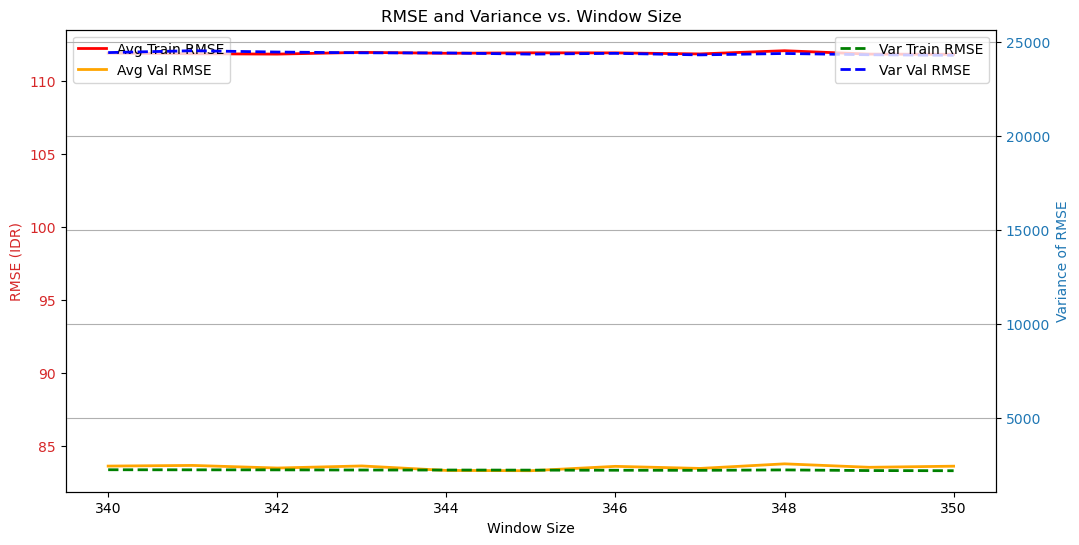

In [25]:
import matplotlib.pyplot as plt

# Ensure you have results_summary populated before running this code
if not results_summary.empty:
    # Plotting RMSE and Variance
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # RMSE Plot
    color = 'tab:red'
    ax1.set_xlabel('Window Size')
    ax1.set_ylabel('RMSE (IDR)', color=color)

    # Plot average RMSE as lines without points
    ax1.plot(results_summary['window_size'].values, results_summary['avg_train_rmse'].values, 
              label='Avg Train RMSE', color='red', linewidth=2)
    ax1.plot(results_summary['window_size'].values, results_summary['avg_val_rmse'].values, 
              label='Avg Val RMSE', color='orange', linewidth=2)

    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    # Create a second y-axis for variance
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Variance of RMSE', color=color)  # Set the label for the second Y axis

    # Plot variance of RMSE as lines without points
    ax2.plot(results_summary['window_size'].values, results_summary['var_train_rmse'].values, 
             label='Var Train RMSE', color='green', linestyle='--', linewidth=2)
    ax2.plot(results_summary['window_size'].values, results_summary['var_val_rmse'].values, 
             label='Var Val RMSE', color='blue', linestyle='--', linewidth=2)

    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title('RMSE and Variance vs. Window Size')
    plt.grid()
    plt.show()
else:
    print("Results summary is empty.")

## Exclude USDT/IDRT

In [ ]:
combined_yahoo_df

,date,open,high,low,close,snp500_close,snp500_volume,ihsg_close
0,2019-10-01,14219.400391,14219.400391,14241.500000,14160.299805,2938.699951,3560750000,6134.770020
1,2019-10-02,14206.000000,14206.000000,14265.099609,14179.900391,2874.929932,3914180000,6051.687988
2,2019-10-03,14188.000000,14188.000000,14247.700195,14135.400391,2855.939941,3515130000,5997.691895
3,2019-10-04,14166.000000,14166.000000,14195.000000,14112.000000,2918.560059,3005600000,6046.129883
4,2019-10-07,14128.000000,14128.000000,14181.500000,14128.000000,2935.679932,2959050000,5988.872070
...,...,...,...,...,...,...,...,...
1201,2024-11-04,15842.000000,15842.000000,15842.000000,15719.000000,5696.509766,3602060000,7415.809082
1202,2024-11-05,15790.000000,15790.000000,15791.900391,15707.700195,5722.100098,3768310000,7451.547852
1203,2024-11-06,15665.000000,15665.000000,15883.099609,14476.500000,5864.890137,6329530000,7363.030762
1204,2024-11-07,15818.200195,15818.200195,15833.799805,15575.000000,5947.209961,4925740000,7243.859863


# Trying to Connect to bloomberg

In [5]:
import requests

# Replace with your actual ICE API endpoint and access token
url = "https://api.ice.com/v1/forex/historical"
headers = {
    "Authorization": "Bearer YOUR_API_KEY"
}
params = {
    "symbol": "EUR/USD",
    "start_date": "2023-01-01",
    "end_date": "2023-12-31",
    "interval": "daily"  # Specify your interval: daily, hourly, etc.
}

# Make the request
response = requests.get(url, headers=headers, params=params)
data = response.json()

# Extract OHLC data
for entry in data['results']:
    print(entry['open'], entry['high'], entry['low'], entry['close'])

ConnectionError: HTTPSConnectionPool(host='api.ice.com', port=443): Max retries exceeded with url: /v1/forex/historical?symbol=EUR%2FUSD&start_date=2023-01-01&end_date=2023-12-31&interval=daily (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7ccf0850c280>: Failed to resolve 'api.ice.com' ([Errno -5] No address associated with hostname)"))